# data used in this project

In [1]:
import FinanceDataReader as fdr
import pandas as pd
from tqdm import tqdm

df_krx = fdr.StockListing('KRX')
kospi_codes = df_krx[df_krx['Market'] == 'KOSPI']['Code']
df = fdr.DataReader('068270', '2017')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2017-01-02,97219,97851,96315,97761,0,0.007430
2017-01-03,97306,97758,95860,96316,0,-0.014781
2017-01-04,96676,96676,94960,95864,0,-0.004693
2017-01-05,96131,97125,95589,96135,0,0.002827
2017-01-06,95683,96045,94870,95142,0,-0.010329


# RSI

현재 추세의 강도를 알기 위한 지표.    
RSI =  100 - 100 / (1 + RS ) = RS / (1 + RS) = AU / (AU + AD)   
RS = AU / AD   
AU = 양의 수익률의 평균  , AD = 음의 수익률의 평균.   
보통 70이 넘어가면 과매도 , 30이 내려가면 과매수 상태를 의심할 수 있다.   
가격과 함께 분석할 수 있다. RSI > 70 , 가격은 하락추세거나 RSI < 30 , 가격은 상승추세면 추세 전환을 의심해본다.  
단독으로 쓰이기보다는 다른 지표의 보조지표로 사용되기 좋은 Osiliator다.   
추세를 정의한다기 보다는 가격이 현재 어떤 상황에 있는지를 판단한다고 생각하면 되겠다. 
window는 평균적으로 14일을 사용한다. 

## 코드 구현 ( 단일 주식에 대해 )

In [24]:
import pandas as pd
import numpy as np

def calculate_rsi(data, time_window):
    diff = data.diff(1).dropna()        # Calculate the price differences
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff > 0]  # Positive price differences
    down_chg[diff < 0] = diff[diff < 0] # Negative price differences
    
    up_chg_avg = up_chg.ewm(alpha=1 / time_window, min_periods=time_window).mean() 
    # alpha는 과거값에 어느정도 가중치를 줄 것인가. 
    down_chg_avg = down_chg.ewm(alpha=1 / time_window, min_periods=time_window).mean() 
    # adjust가 True (default) 이면 Wilder`s Moving Average 방식을 사용한다. 간단히 최근 값에 더 큰 가중치를 부여하는 방법이다.

    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 100 - 100 / (1 + rs)
    
    return rsi

In [25]:
df = fdr.DataReader('068270', '2017')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2017-01-02,97219,97851,96315,97761,0,0.007430
2017-01-03,97306,97758,95860,96316,0,-0.014781
2017-01-04,96676,96676,94960,95864,0,-0.004693
2017-01-05,96131,97125,95589,96135,0,0.002827
2017-01-06,95683,96045,94870,95142,0,-0.010329


<AxesSubplot:xlabel='Date'>

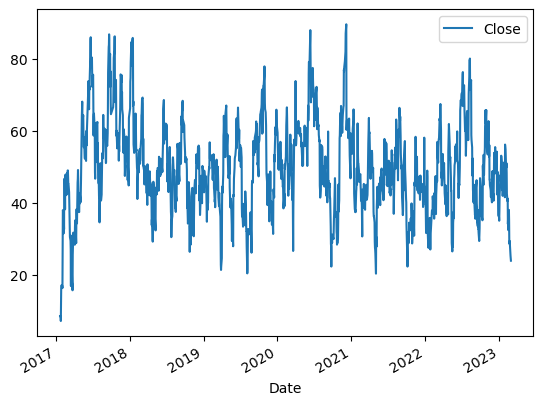

In [57]:
rsi = calculate_rsi(df[['Close']], time_window=14)
rsi.plot()

In [58]:
len(rsi), len(close)

(1515, 1516)

In [69]:
rsi['up_down'] = rsi['Close'].apply(lambda x : 1 if x > 70 else -1 if x < 30 else 0) # up : 1, down : -1 
rsi

,Close,up_down
Date,,
2017-01-03,NaN,0
2017-01-04,NaN,0
2017-01-05,NaN,0
2017-01-06,NaN,0
2017-01-09,NaN,0
...,...,...
2023-02-23,28.628845,-1
2023-02-24,29.404231,-1
2023-02-27,26.051455,-1


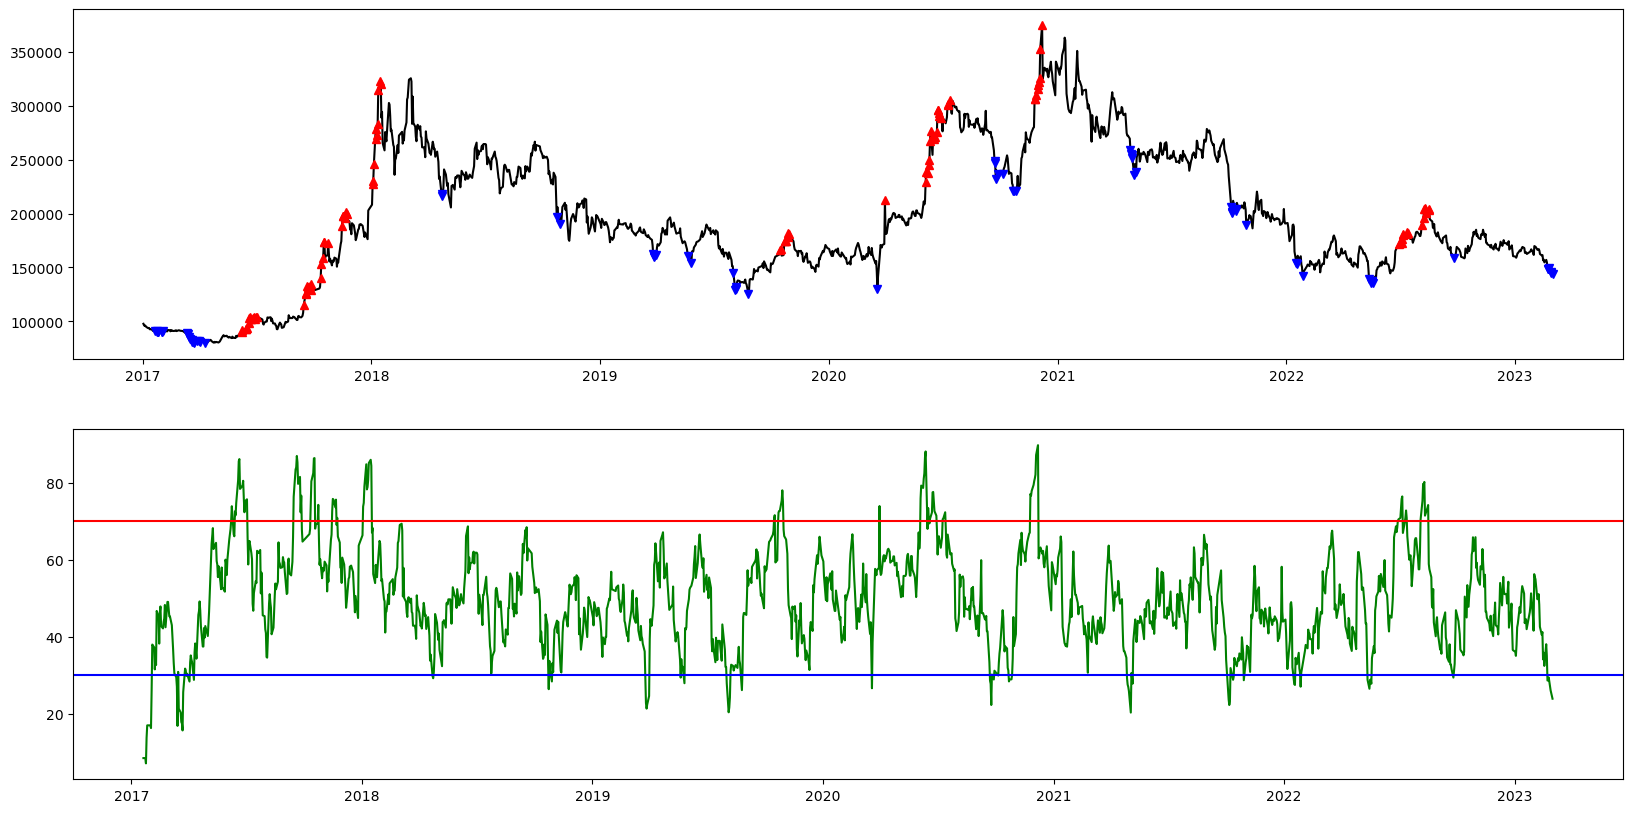

In [96]:
import matplotlib.pyplot as plt

df = fdr.DataReader('068270', '2017')
close = df[['Close']]
rsi = calculate_rsi(close, time_window=14)
rsi['up_down'] = rsi['Close'].apply(lambda x : 1 if x > 70 else -1 if x < 30 else 0) # up : 1, down : -1 

fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].plot(close, color='black')

axes[1].plot(rsi[['Close']], color='g')
axes[1].axhline(y=30, color='blue', linestyle='-')
axes[1].axhline(y=70, color='red', linestyle='-')

rsi_index = rsi.index
for index in rsi_index:
    if rsi.loc[index, 'up_down'] == 1:
        axes[0].plot(index, close.loc[index][0], marker='^', color='red')
    if rsi.loc[index, 'up_down'] == -1:
        axes[0].plot(index, close.loc[index][0], marker='v', color='blue')

고려해야봐야 하는 것 2가지. ( 기술적 지표로 쓰임을 증명하기 위해 )   
- signal이 발생하고 추세가 전환된 확률은 얼마나 되는가?
- MA와 결합해서 추세를 맞춘 확률은 얼마나 되는가?

## 1번 검정 
signal이 발생하고 추세가 전환된 확률은 얼마나 되는가?   
고려할 점 2가지.   
- signal이 몇일 연속으로 발생해야 발생했다고 할 것인가.   
- 추세를 어떻게 정의할 것인가.

In [104]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [120]:
rsi_index = rsi.index.tolist()
cnt_list = []
cnt_up = 0
cnt_down = 0

for index in rsi_index:
    if rsi.loc[index, 'up_down'] == 1:
        cnt_up += 1
    else:
        cnt_list.append(cnt_up)
        cnt_up = 0
        
        
    if rsi.loc[index, 'up_down'] == -1:
        cnt_down += 1
    else:
        cnt_list.append(cnt_down) 
        cnt_down = 0

cnt_list = [x for x in cnt_list if x > 0]
print(max(cnt_list), min(cnt_list), sum(cnt_list) / len(cnt_list))

14 1 3.5531914893617023


평균 3.55번의 신호가 연속으로 발생.   
3번 연속 신호가 발생한 후 추세가 바뀌는지 확인하자. 

추세정의 : 신호가 연속 3일 발생한 이후 14일 평균 수익률

<AxesSubplot:xlabel='Date'>

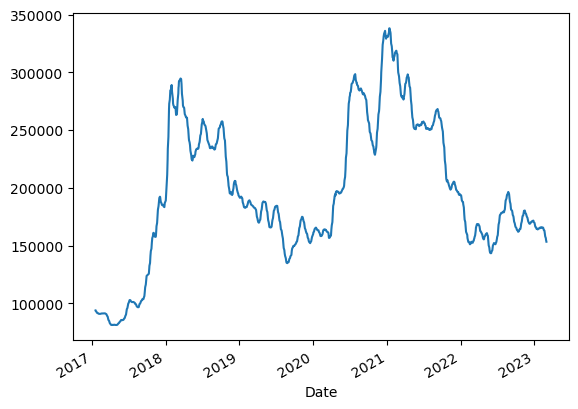

In [126]:
trend = df['Close'].rolling(window=14).mean()
trend.plot()

In [137]:
from datetime import datetime, timedelta

In [167]:
cnt_up_success = 0
cnt_down_success = 0

close_return = df['Close'].pct_change()

for index in rsi_index:
    index_tmp.append(index)
    if rsi.loc[index, 'up_down'] == 1:
        cnt_up += 1
        if cnt_up >= 3:
            if close_return.loc[index:index + timedelta(14)].mean() < 0:
                cnt_up_success += 1
            
    else:
        cnt_list.append(cnt_up)
        cnt_up = 0
        
        
    if rsi.loc[index, 'up_down'] == -1:
        cnt_down += 1
        if cnt_down >= 3:
            if close_return.loc[index:index + timedelta(14)].mean() > 0:
                cnt_down_success += 1
    else:
        cnt_list.append(cnt_down) 
        cnt_down = 0
        
        
N = len(rsi[rsi['up_down'] != 0]) # 시그널의 총 개수
N_up = len(rsi[rsi['up_down'] == 1]) # up 시그널의 개수
N_down = len(rsi[rsi['up_down'] == 1]) # down 시그널의 개수

cnt_success = cnt_up_success + cnt_down_success
print(f"# of success : {cnt_success} , ratio : {cnt_success / N :.2f} ,"
      f"up : {cnt_up_success / N_up:.2f} , down : {cnt_down_success / N_down:.2f}")

# of success : 55 , ratio : 0.32 ,up : 0.35 , down : 0.20


전체 시그널 중 추세 전환을 맞춘 건 0.32 , up이 down보다 더 잘 맞췄다.   
다만 이는 한 종목에 대한 것이기 때문에 여러 종목으로 확장해 이 값에 대한 통계를 내봐도 좋겠다.  
그리고 이 승률을 이용해 또 다른 전략을 만들어 볼 수도 있겠다.

### 함수화

In [172]:
def get_cnt_list(rsi, verbose=True):
    """
    시그널이 연속으로 발생하는 count에 대한 정보를 제공한다. 
    """
    rsi_index = rsi.index.tolist()
    cnt_list = []
    cnt_up = 0
    cnt_down = 0

    for index in rsi_index:
        if rsi.loc[index, 'up_down'] == 1:
            cnt_up += 1
        else:
            cnt_list.append(cnt_up)
            cnt_up = 0


        if rsi.loc[index, 'up_down'] == -1:
            cnt_down += 1
        else:
            cnt_list.append(cnt_down) 
            cnt_down = 0

    cnt_list = [x for x in cnt_list if x > 0]
    if verbose:
        print(max(cnt_list), min(cnt_list), sum(cnt_list) / len(cnt_list))
    return cnt_list

In [192]:
def get_success_cnt(close, rsi, verbose=True):
    """
    추세전환에 성공한 횟수를 return. 
    return : total_ratio, up_ratio, down_ratio
    """
    cnt_up_success = 0
    cnt_down_success = 0
    cnt_up = 0
    cnt_down = 0
    
    close_return = df['Close'].pct_change()
    
    rsi_index = rsi.index.tolist()

    for index in rsi_index:
        if rsi.loc[index, 'up_down'] == 1:
            cnt_up += 1
            if cnt_up >= 3:
                if close_return.loc[index:index + timedelta(14)].mean() < 0:
                    cnt_up_success += 1

        else:
            cnt_list.append(cnt_up)
            cnt_up = 0


        if rsi.loc[index, 'up_down'] == -1:
            cnt_down += 1
            if cnt_down >= 3:
                if close_return.loc[index:index + timedelta(14)].mean() > 0:
                    cnt_down_success += 1
        else:
            cnt_list.append(cnt_down) 
            cnt_down = 0
        
        
    N = len(rsi[rsi['up_down'] != 0]) # 시그널의 총 개수
    N_up = len(rsi[rsi['up_down'] == 1]) # up 시그널의 개수
    N_down = len(rsi[rsi['up_down'] == 1]) # down 시그널의 개수

    cnt_success = cnt_up_success + cnt_down_success
    if not N == 0:
        total_ratio = cnt_success / N
    else:
        total_ratio = 0
    if not N_up == 0:
        up_ratio = cnt_up_success / N_up
    else:
        up_ratio = 0
    if not N_down == 0:
        down_ratio = cnt_down_success / N_down
    else:
        down_ratio = 0
    
    if verbose:
        print(f"# of success : {cnt_success} , ratio : {total_ratio :.2f} ,"
              f"up : {up_ratio:.2f} , down : {down_ratio:.2f}")
    return total_ratio, up_ratio, down_ratio

In [193]:
total_ratio_list = []

df_krx = fdr.StockListing('KRX')
kospi_codes = df_krx[df_krx['Market'] == 'KOSPI']['Code']

start_date='2017'; end_date=None

for i, code in enumerate(kospi_codes):
    df = fdr.DataReader(code, start=start_date, end=end_date)
    close = df[['Close']]
    rsi = calculate_rsi(close, time_window=14)
    rsi['up_down'] = rsi['Close'].apply(lambda x : 1 if x > 70 else -1 if x < 30 else 0) # up : 1, down : -1 
    total_ratio, up_ratio, down_ratio = get_success_cnt(close, rsi, verbose=False)
    print(f"{i / len(kospi_codes):.2f} / {code} / {total_ratio:.2f}")
    total_ratio_list.append(total_ratio)

0.00 / 005930 / 0.29
0.00 / 373220 / 0.48
0.00 / 000660 / 0.24
0.00 / 207940 / 0.34
0.00 / 006400 / 0.25
0.01 / 051910 / 0.24
0.01 / 005935 / 0.27
0.01 / 005380 / 0.23
0.01 / 035420 / 0.18
0.01 / 000270 / 0.27
0.01 / 005490 / 0.23
0.01 / 035720 / 0.24
0.01 / 028260 / 0.25
0.01 / 105560 / 0.23
0.01 / 012330 / 0.40
0.02 / 068270 / 0.32
0.02 / 055550 / 0.15
0.02 / 066570 / 0.25
0.02 / 003670 / 0.18
0.02 / 096770 / 0.29
0.02 / 034730 / 0.26
0.02 / 032830 / 0.22
0.02 / 086790 / 0.22
0.02 / 003550 / 0.25
0.03 / 323410 / 0.30
0.03 / 033780 / 0.28
0.03 / 010130 / 0.26
0.03 / 015760 / 0.25
0.03 / 011200 / 0.29
0.03 / 009150 / 0.16
0.03 / 051900 / 0.31
0.03 / 034020 / 0.28
0.03 / 000810 / 0.25
0.03 / 017670 / 0.20
0.04 / 018260 / 0.19
0.04 / 036570 / 0.21
0.04 / 329180 / 0.30
0.04 / 010950 / 0.28
0.04 / 316140 / 0.34
0.04 / 003490 / 0.16
0.04 / 090430 / 0.21
0.04 / 259960 / 0.13
0.04 / 024110 / 0.26
0.05 / 377300 / 0.40
0.05 / 009830 / 0.18
0.05 / 030200 / 0.20
0.05 / 011170 / 0.15
0.05 / 352820

0.41 / 126720 / 0.00
0.42 / 016580 / 0.28
0.42 / 002710 / 0.18
0.42 / 003200 / 0.23
0.42 / 005810 / 0.33
0.42 / 00088K / 0.30
0.42 / 003570 / 0.24
0.42 / 002320 / 0.11
0.42 / 126560 / 0.34
0.42 / 00104K / 0.27
0.43 / 003070 / 0.21
0.43 / 077970 / 0.18
0.43 / 071840 / 0.21
0.43 / 200880 / 0.25
0.43 / 008350 / 0.33
0.43 / 002960 / 0.23
0.43 / 009290 / 0.33
0.43 / 024720 / 0.25
0.43 / 000050 / 0.39
0.43 / 030210 / 0.23
0.44 / 000490 / 0.26
0.44 / 009680 / 0.27
0.44 / 001500 / 0.32
0.44 / 213500 / 0.24
0.44 / 002150 / 0.18
0.44 / 037710 / 0.31
0.44 / 004250 / 0.28
0.44 / 055490 / 0.36
0.44 / 271980 / 0.33
0.45 / 084690 / 0.26
0.45 / 272550 / 0.30
0.45 / 035510 / 0.32
0.45 / 001070 / 0.23
0.45 / 077500 / 0.25
0.45 / 003610 / 0.23
0.45 / 029460 / 0.26
0.45 / 002020 / 0.27
0.45 / 001630 / 0.31
0.45 / 004380 / 0.24
0.46 / 018470 / 0.27
0.46 / 900140 / 0.28
0.46 / 071055 / 0.32
0.46 / 139990 / 0.25
0.46 / 001470 / 0.27
0.46 / 293480 / 0.22
0.46 / 001780 / 0.32
0.46 / 117580 / 0.22
0.46 / 081000

0.83 / 005360 / 0.27
0.83 / 001140 / 0.25
0.83 / 092780 / 0.28
0.83 / 014130 / 0.37
0.83 / 120115 / 0.28
0.84 / 090080 / 0.30
0.84 / 010660 / 0.21
0.84 / 001380 / 0.26
0.84 / 009770 / 0.28
0.84 / 019180 / 0.39
0.84 / 001620 / 0.32
0.84 / 015260 / 0.33
0.84 / 133820 / 0.37
0.84 / 078935 / 0.24
0.85 / 119650 / 0.29
0.85 / 012200 / 0.26
0.85 / 005750 / 0.25
0.85 / 021050 / 0.22
0.85 / 000105 / 0.30
0.85 / 004100 / 0.33
0.85 / 006805 / 0.24
0.85 / 006570 / 0.41
0.85 / 001020 / 0.29
0.85 / 45014K / 0.00
0.86 / 007120 / 0.34
0.86 / 003925 / 0.35
0.86 / 020760 / 0.24
0.86 / 011300 / 0.26
0.86 / 005305 / 0.25
0.86 / 000725 / 0.20
0.86 / 023150 / 0.37
0.86 / 001275 / 0.28
0.86 / 006200 / 0.26
0.87 / 000215 / 0.37
0.87 / 007610 / 0.30
0.87 / 005820 / 0.38
0.87 / 010400 / 0.40
0.87 / 051630 / 0.29
0.87 / 010770 / 0.29
0.87 / 025530 / 0.24
0.87 / 004920 / 0.28
0.87 / 37550L / 0.30
0.87 / 023960 / 0.26
0.88 / 000040 / 0.31
0.88 / 012280 / 0.32
0.88 / 044380 / 0.31
0.88 / 002690 / 0.28
0.88 / 011090

<AxesSubplot:>

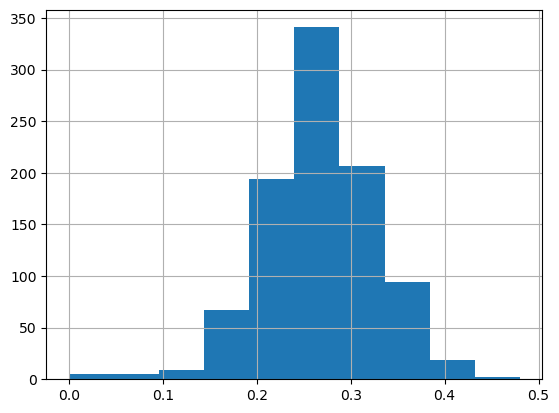

In [198]:
pd.Series(total_ratio_list).hist()

In [195]:
N = len(total_ratio_list)
sum(total_ratio_list) / N

0.26653168382260434

## 2번 검정


# Moving Average 

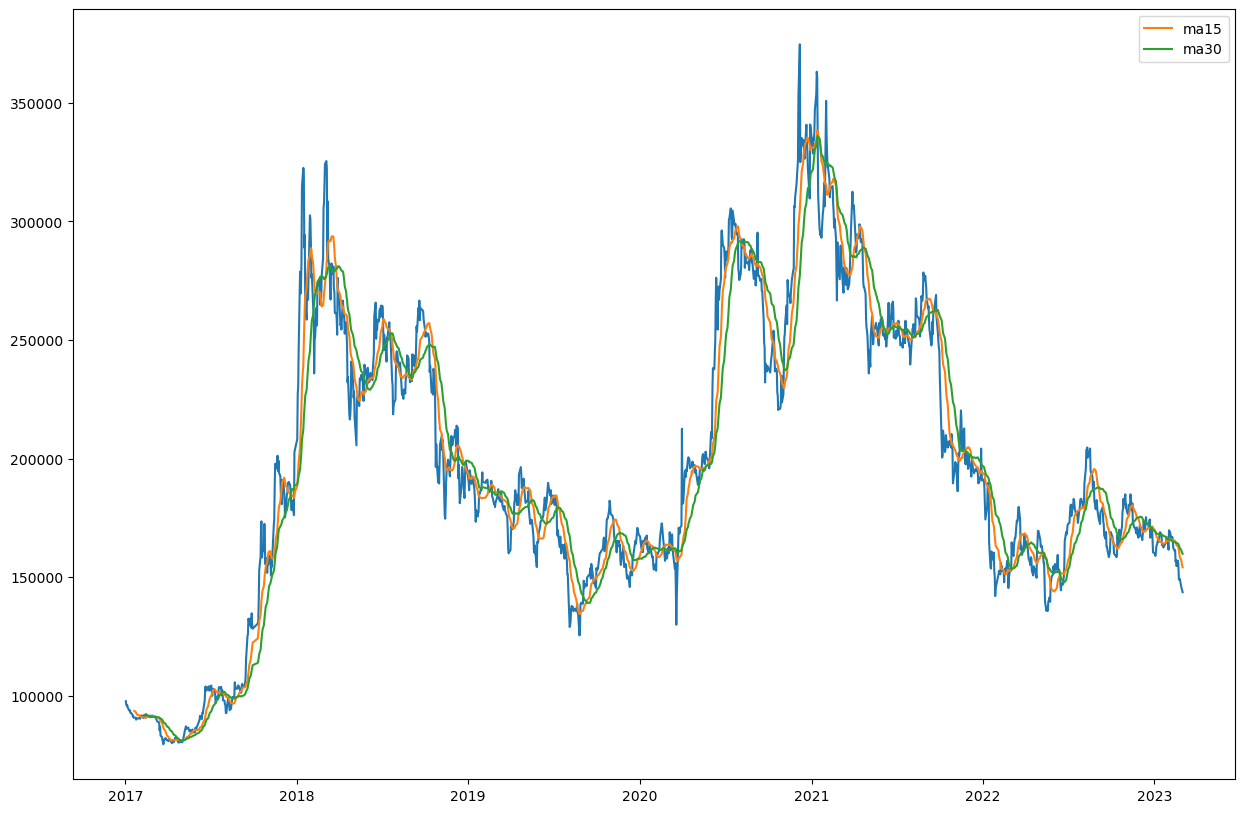

In [206]:
df = fdr.DataReader('068270', '2017')
close = df[['Close']]

plt.figure(figsize=(15, 10))
plt.plot(close)

ma15 = close.rolling(window=15).mean()
plt.plot(ma15, label='ma15')

ma30 = close.rolling(window=30).mean()
plt.plot(ma30, label='ma30')

plt.legend()
plt.show()

# Bollinger Band
볼린저가 만든 지표.   
보통 SMA , upper band(+2 sigma) , lower band(-2 sigma). 3가지 선을 사용.   
같은 지표지만 SMA이 위 아래 밴드를 벗어났을 때 신호를 다르게 해석하여 전략을 구성한다.   
( 추세 추종, 역추세추종 )  -> 시장 국면 분석으로 확률적 우위를 올려볼 수 있겠다.  

어쨌든 이 지표가 의미하는 것은 2std가 넘어갈정도의 가격상승이라면 의미를 생각해봐야한다는 것이다.   
다시 평균회귀하던가 , 그대로 추세를 이어갈 것인가.    
이 중 어떤 것이 옳은지는 알 수 없기에 다른 지표와 함께 사용하여야만 한다. 

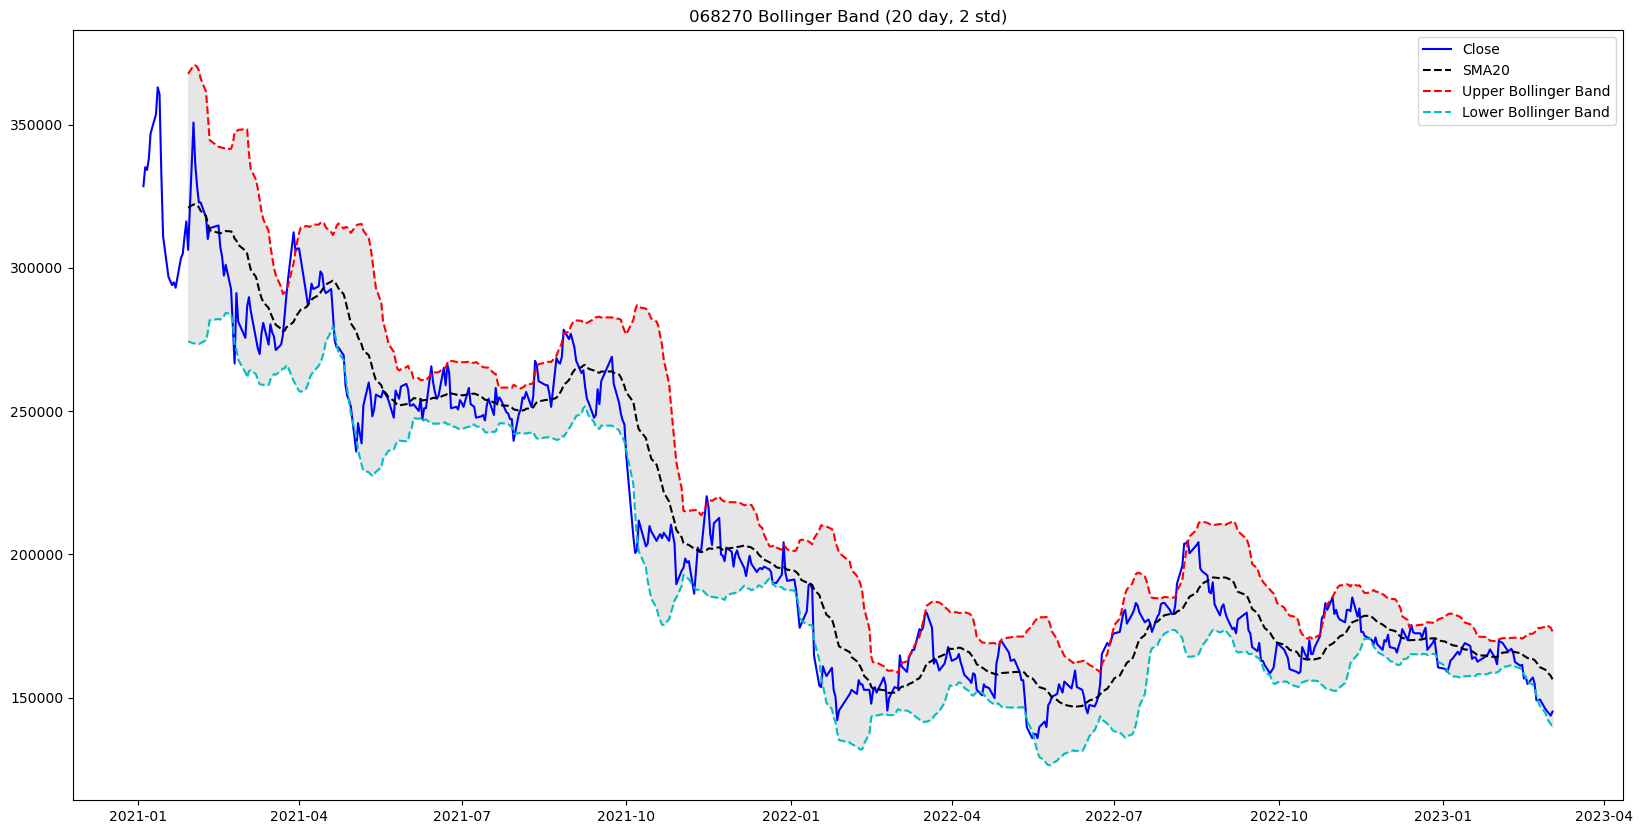

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# Load stock data

stock = '068270'; start = '2021'; end = None 
df = fdr.DataReader(stock, start, end)
close = df[['Close']]

# Calculate 20-day moving average and standard deviation
ma20 = df["Close"].rolling(window=20).mean()
std = df["Close"].rolling(window=20).std()
upper_band = ma20 + std * 2
lower_band = ma20 - std * 2


# Plot Bollinger Bands
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df.index, df["Close"], label="Close", color='#0000ff')
ax.plot(ma20, 'k--',label="SMA20")
ax.plot(upper_band, 'r--', label="Upper Bollinger Band")
ax.plot(lower_band, 'c--', label="Lower Bollinger Band")
ax.fill_between(df.index, upper_band, lower_band, color='0.9')
ax.set_title(stock + ' Bollinger Band (20 day, 2 std)')
ax.legend()
plt.show()

## %b
%b = ( 종가 - 하단 볼린저 밴드 ) / ( 상단 볼린저 밴드 - 하단 볼린저 밴드 )   
가격이 볼린저 밴드 사이에 어느정도 위치하는지를 나타낸다.    
트레이딩 기회를 제공해주는 정보.  0.8 이상이면 과매수 상태, 0.2이하면 과매도 상태를 의심해볼 수 있다.   
또 진입에 대한 정보도 제공해주는데, 0.5를 기준으로 bullish or bearish. 판단.

맥락에 따라 해석이 달라질 것 같다. 시장국면분석이 중요한 이유.

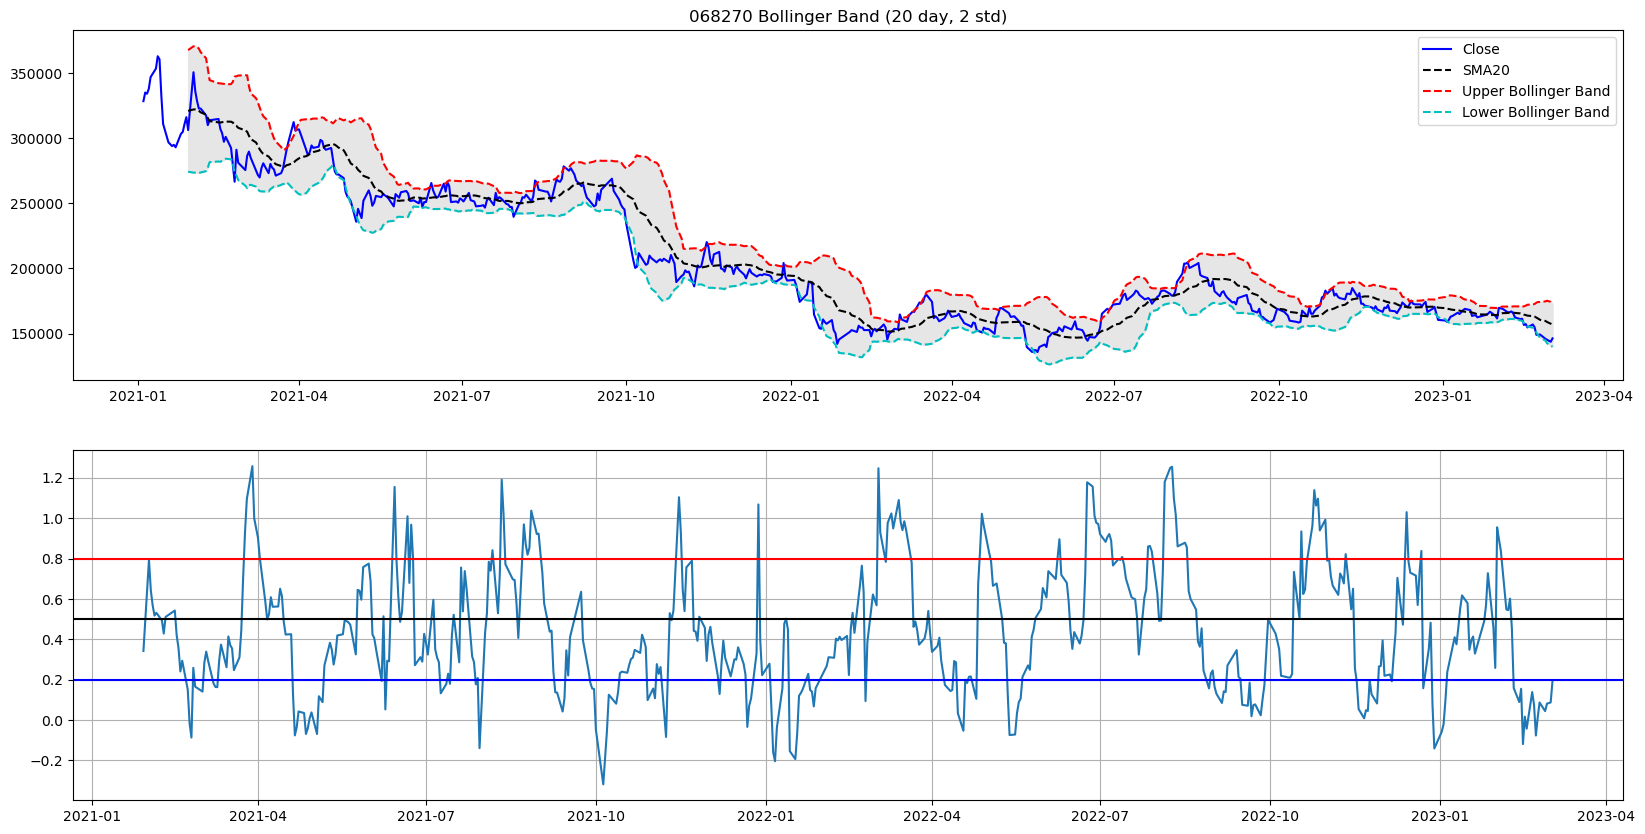

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# Load stock data
stock = '068270'; start = '2021'; end = None 
df = fdr.DataReader(stock, start, end)
close = df['Close']

# Calculate 20-day moving average and standard deviation
ma20 = df["Close"].rolling(window=20).mean()
std = df["Close"].rolling(window=20).std()

# calculate bollinger band.
upper_band = ma20 + std * 2
lower_band = ma20 - std * 2

# calculate pb.
pb = (close - lower_band) / (upper_band - lower_band)

# Plot Bollinger Bands
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].plot(df.index, df["Close"], label="Close", color='#0000ff')
axes[0].plot(ma20, 'k--',label="SMA20")
axes[0].plot(upper_band, 'r--', label="Upper Bollinger Band")
axes[0].plot(lower_band, 'c--', label="Lower Bollinger Band")
axes[0].fill_between(df.index, upper_band, lower_band, color='0.9')
axes[0].set_title(stock + ' Bollinger Band (20 day, 2 std)')
axes[0].legend()

axes[1].plot(pb)
axes[1].grid(True)
axes[1].axhline(y=0.5, color='black')
axes[1].axhline(y=0.8, color='red')
axes[1].axhline(y=0.2, color='blue')

plt.show()

## Bandwidth

가격의 변동성을 판단하기 위해 활용되는 지표.   
bandwidth = (upper band - lower band) / middle band * 100   
= (middle band + 2 * std - midd bad + 2 * std ) / middle band * 100   
= 4 std / middle band * 100



low bandwidth -> ranging , high bandwidth -> trending.  

rsi, moving average와 함께 쓰인다. 추세가 맞는지 확인하기 위해서.   
bandwith가 상승하고 rsi가 50이상이라면 상승 추세라고 생각해볼 수 있다.    
bandwith를 확인해서 적절한 전략을 수정할 수 있다.

그냥 std를 쓰는 것과 차이는 뭐지?    
standardized measure, 다른 자산군과 비교할 때 용이하다. percentage level이라서.

결론적으로는 의미가 있는 지표인지 잘 모르겠다.   
그냥 변동성을 추정하는 한 방법인데, 큰 의미가 없어보인다.

## MFI (Money Flow Index)

MFI = 100 - ( 100 / ( 1 + 긍정적 현금 흐름 / 부정적 현금 흐름 ) )   
긍정적 현금 흐름 : 중심 가격이 전일보다 상승한 날들의 현금 흐름의 합   
부정적 현금 흐름 : 중심 가격이 전일보다 하락한 날들의 현금 흐름의 합   

가격과 거래량 데이터로 매도, 매수 압력을 추정하기 위한 지표.  
above 80 -> overbought condition , below 20 -> oversold condtion.   
%b와 함께 전략으로 많이 사용된다.   

%b can be used to identify potential entry and exit points for trades. For example, a buy signal may be generated when the MFI crosses above the oversold level (20) and the %b value is below 0.2. This indicates that the stock may be oversold and due for a rebound.

Conversely, a sell signal may be generated when the MFI crosses below the overbought level (80) and the %b value is above 0.8. This indicates that the stock may be overbought and due for a correction.

Another popular strategy using MFI and %b is the divergence strategy. In this strategy, traders look for divergences between the MFI and price action. For example, if the MFI is making higher highs while the price is making lower lows, this may indicate that there is bullish divergence and that the stock may be due for a reversal. Traders can then look for confirmation by waiting for the %b value to cross above the oversold level or for other technical indicators to generate buy signals.

정리하자면, %b는 과매수, 과매도에 대한 정보를 알려준다.  그리고 MFI는 매도, 매수 압력에 대한 정보를 알려주고.   
따라서 MFI와 %b 시그널의 교집합을 통해 전략을 구성할 수 있다.   
divergence strategy : MFI는 올라가는데 가격은 내려간다면 , 곧 bullish divergence가 발생할 수 있음을 추정해볼 수 있다.   

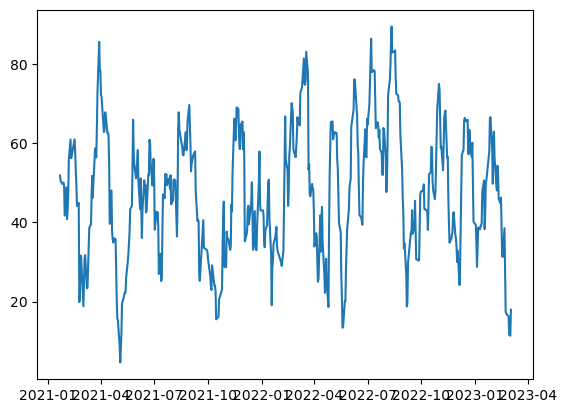

In [68]:
tock = '068270'; start = '2021'; end = None 
df = fdr.DataReader(stock, start, end)

high = df['High']
low = df['Low']
close = df['Close']
volume = df['Volume']

typical_price = (high + low + close) / 3
raw_money_flow = typical_price * volume

positive_flow = pd.Series(0, index=close.index)
negative_flow = pd.Series(0, index=close.index)

positive_flow[1:] = (typical_price.diff()[1:] > 0) * raw_money_flow[1:]
negative_flow[1:] = (typical_price.diff()[1:] < 0) * raw_money_flow[1:]

n = 14
positive_mf = positive_flow.rolling(window=n).sum()
negative_mf = negative_flow.rolling(window=n).sum()

mfi = 100 - 100 / (1 + (positive_mf / negative_mf))

plt.plot(mfi)

In [136]:
tock = '068270'; start = '2021'; end = None 
df = fdr.DataReader(stock, start, end)

def get_mfi(df, n):
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']

    typical_price = (high + low + close) / 3
    raw_money_flow = typical_price * volume

    positive_flow = pd.Series(0, index=close.index)
    negative_flow = pd.Series(0, index=close.index)

    positive_flow[1:] = (typical_price.diff()[1:] > 0) * raw_money_flow[1:]
    negative_flow[1:] = (typical_price.diff()[1:] < 0) * raw_money_flow[1:]

    positive_mf = positive_flow.rolling(window=n).sum()
    negative_mf = negative_flow.rolling(window=n).sum()

    mfi = 100 - 100 / (1 + (positive_mf / negative_mf))
    
    return mfi

In [164]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


# Define %b and MFI functions
def bollinger_bands(close, window=20, std=2):
    rolling_mean = close.rolling(window=window).mean()
    rolling_std = close.rolling(window=window).std()
    upper_band = rolling_mean + std * rolling_std
    lower_band = rolling_mean - std * rolling_std
    return upper_band, lower_band, rolling_mean

def percent_b(close, upper_band, lower_band):
    percent_b = (close - lower_band) / (upper_band - lower_band)
    return percent_b

def money_flow_index(high, low, close, volume, n=14):
    typical_price = (high + low + close) / 3
    raw_money_flow = typical_price * volume

    positive_flow = pd.Series(0, index=close.index)
    negative_flow = pd.Series(0, index=close.index)

    positive_flow[1:] = (typical_price.diff(1)[1:] > 0) * raw_money_flow[1:]
    negative_flow[1:] = (typical_price.diff(1)[1:] < 0) * raw_money_flow[1:]

    positive_mf = positive_flow.rolling(n).sum()
    negative_mf = negative_flow.rolling(n).sum()

    mfi = 100 - 100 / (1 + (positive_mf / negative_mf))
    return mfi

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# data
stock = '068270'; start = '2021'; end = None 
df = fdr.DataReader(stock, start, end)

# Calculate %b and MFI
df['upper_band'], df['lower_band'], df['middle_band'] = bollinger_bands(df['Close'])
df['percent_b'] = percent_b(df['Close'], df['upper_band'], df['lower_band'])
df['mfi'] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])

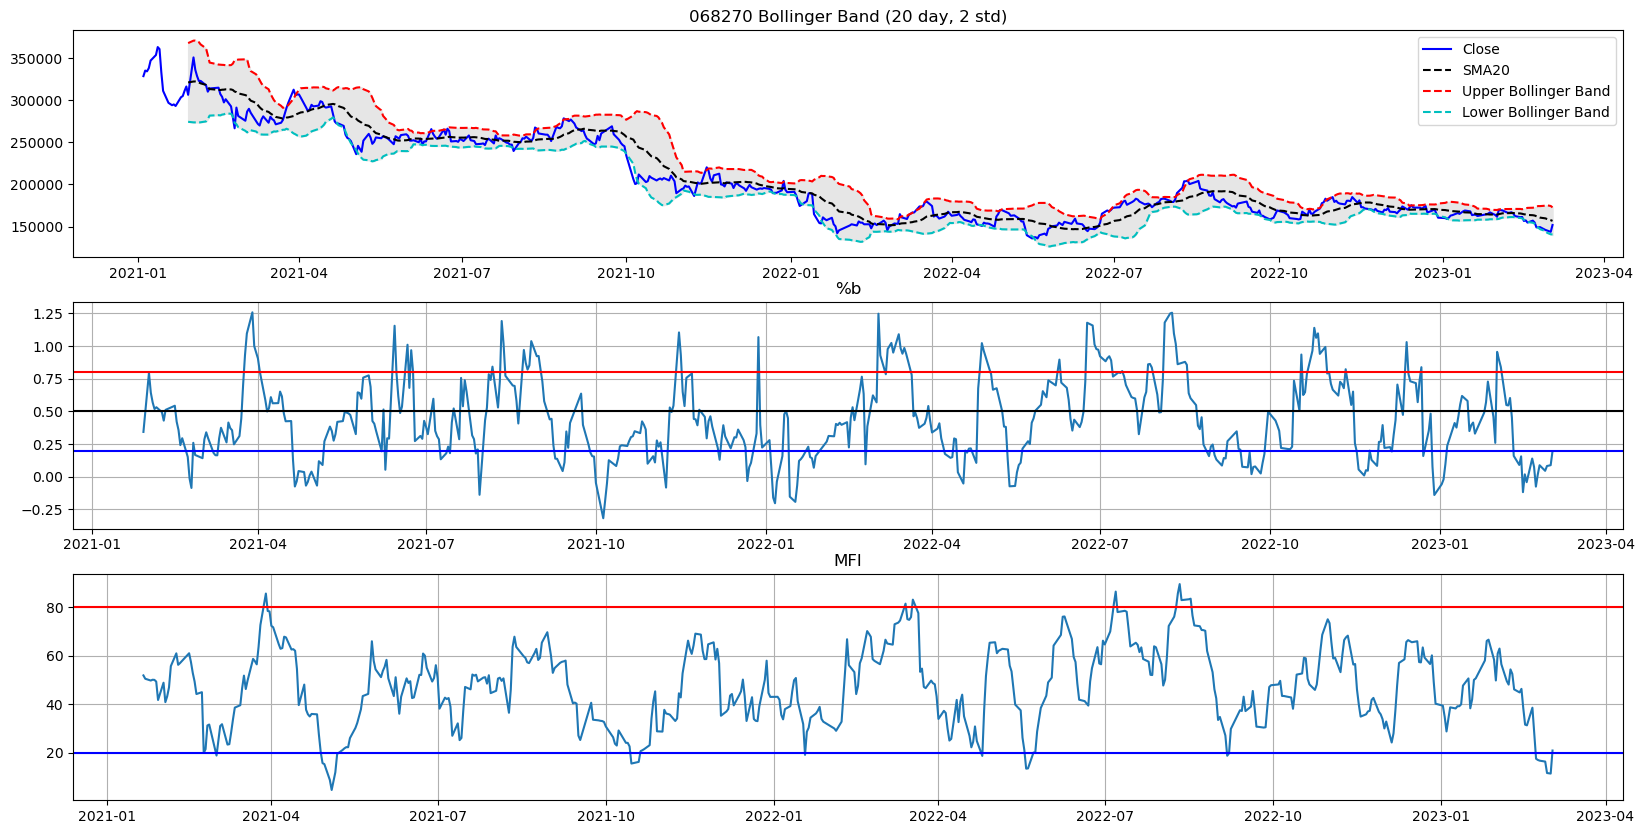

In [105]:
# Plot Bollinger Bands
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].plot(df.index, df["Close"], label="Close", color='#0000ff')
axes[0].plot(df['middle_band'], 'k--',label="SMA20")
axes[0].plot(df['upper_band'], 'r--', label="Upper Bollinger Band")
axes[0].plot(df['lower_band'], 'c--', label="Lower Bollinger Band")
axes[0].fill_between(df.index, df['upper_band'], df['lower_band'], color='0.9')
axes[0].set_title(stock + ' Bollinger Band (20 day, 2 std)')
axes[0].legend()

axes[1].plot(df['percent_b'])
axes[1].grid(True)
axes[1].axhline(y=0.5, color='black')
axes[1].axhline(y=0.8, color='red')
axes[1].axhline(y=0.2, color='blue')
axes[1].set_title('%b')


axes[2].plot(df['mfi'])
axes[2].set_title('MFI')
axes[2].grid(True)
axes[2].axhline(y=80, color='red')
axes[2].axhline(y=20, color='blue')

plt.show()

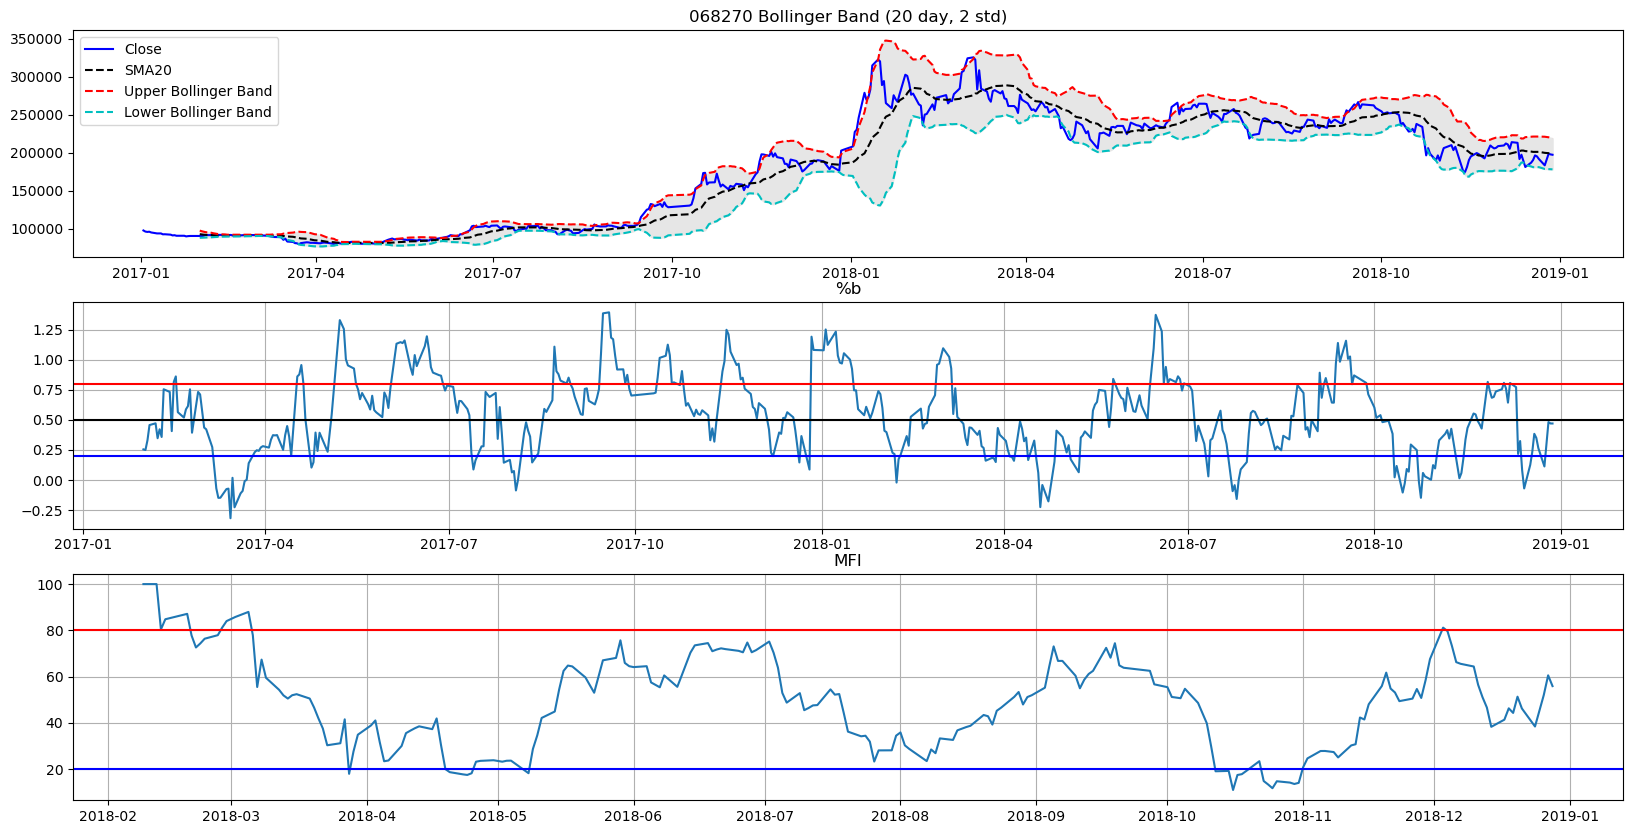

In [151]:
# data
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

# Calculate %b and MFI
df['upper_band'], df['lower_band'], df['middle_band'] = bollinger_bands(df['Close'])
df['percent_b'] = percent_b(df['Close'], df['upper_band'], df['lower_band'])
df['mfi'] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])


# Plot Bollinger Bands
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].plot(df.index, df["Close"], label="Close", color='#0000ff')
axes[0].plot(df['middle_band'], 'k--',label="SMA20")
axes[0].plot(df['upper_band'], 'r--', label="Upper Bollinger Band")
axes[0].plot(df['lower_band'], 'c--', label="Lower Bollinger Band")
axes[0].fill_between(df.index, df['upper_band'], df['lower_band'], color='0.9')
axes[0].set_title(stock + ' Bollinger Band (20 day, 2 std)')
axes[0].legend()

axes[1].plot(df['percent_b'])
axes[1].grid(True)
axes[1].axhline(y=0.5, color='black')
axes[1].axhline(y=0.8, color='red')
axes[1].axhline(y=0.2, color='blue')
axes[1].set_title('%b')


axes[2].plot(df['mfi'])
axes[2].set_title('MFI')
axes[2].grid(True)
axes[2].axhline(y=80, color='red')
axes[2].axhline(y=20, color='blue')

plt.show()

## 전략구현

### %b와 MFI를 이용한 추세추종

%b > 0.8 , MFI > 80 -> 매수.   
%b < 0.2 , MFI < 20 -> 매도.

즉 매수 강세가 강하고 가격의 위치가 2std보다 위에 있을 때 매수하고,   
매도 강세가 강하고 가격의 위치가 2std보다 아래에 있을 때 매도한다. 

굉장히 직관적인 전략.   
다만 매수 후에는 매도신호가 날 때까지는 대기하는 건가?

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# data
stock = '068270'; start = '2021'; end = None 
df = fdr.DataReader(stock, start, end)

# Calculate %b and MFI
df['upper_band'], df['lower_band'], df['middle_band'] = bollinger_bands(df['Close'])
df['percent_b'] = percent_b(df['Close'], df['upper_band'], df['lower_band'])
df['mfi'] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])
df['up_signal'] = False
df['down_signal'] = False

In [111]:
df.head(1)

,Open,High,Low,Close,Volume,Change,upper_band,lower_band,middle_band,percent_b,mfi,up_signal,down_signal
Date,,,,,,,,,,,,,
2021-01-04,332320,335157,324285,328540,2122278,-0.032035,NaN,NaN,NaN,NaN,NaN,False,False


In [113]:
for i in range(len(df)):
    if df.iloc[i, 9] > 0.8 and df.iloc[i, 10] > 80: # %b > 0.8 and mfi > 80
        df.iloc[i, 11] = True
    if df.iloc[i, 9] < 0.2 and df.iloc[i, 10] < 20: # %b < 0.2 and mfi < 20
        df.iloc[i, 12] = True

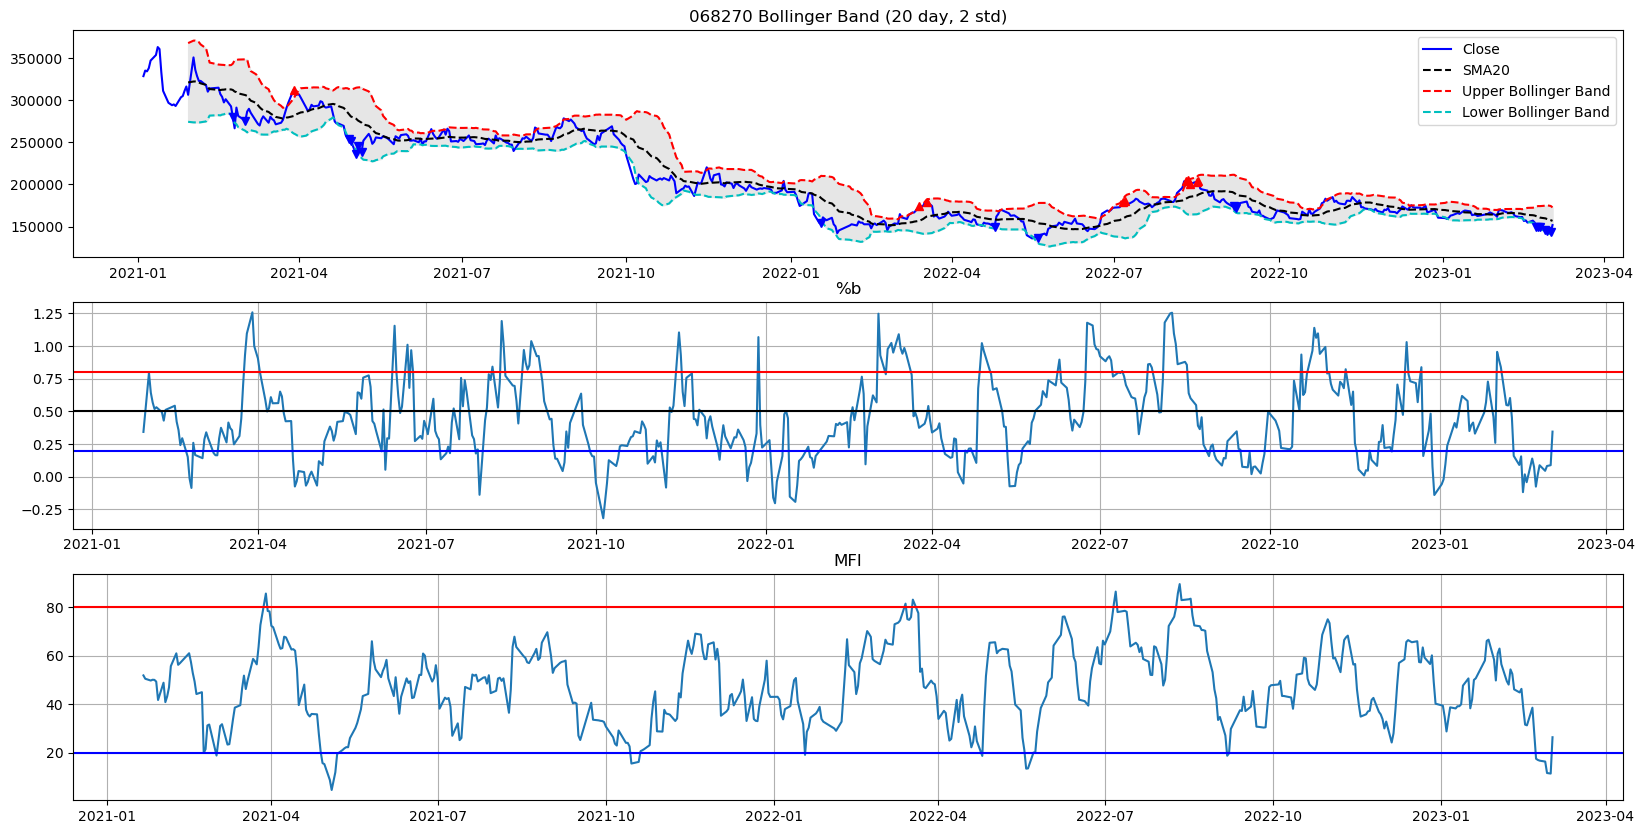

In [156]:
# Plot Bollinger Bands
def plot_trending(stock, start, end=None):
    # get data
    df = fdr.DataReader(stock, start, end)

    # Calculate %b and MFI
    df['upper_band'], df['lower_band'], df['middle_band'] = bollinger_bands(df['Close'])
    df['percent_b'] = percent_b(df['Close'], df['upper_band'], df['lower_band'])
    df['mfi'] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])
    df['up_signal'] = False
    df['down_signal'] = False
    
    fig, axes = plt.subplots(3, 1, figsize=(20, 10))
    axes[0].plot(df.index, df["Close"], label="Close", color='#0000ff')
    axes[0].plot(df['middle_band'], 'k--',label="SMA20")
    axes[0].plot(df['upper_band'], 'r--', label="Upper Bollinger Band")
    axes[0].plot(df['lower_band'], 'c--', label="Lower Bollinger Band")
    axes[0].fill_between(df.index, df['upper_band'], df['lower_band'], color='0.9')
    axes[0].set_title(stock + ' Bollinger Band (20 day, 2 std)')
    axes[0].legend()

    axes[1].plot(df['percent_b'])
    axes[1].grid(True)
    axes[1].axhline(y=0.5, color='black')
    axes[1].axhline(y=0.8, color='red')
    axes[1].axhline(y=0.2, color='blue')
    axes[1].set_title('%b')


    axes[2].plot(df['mfi'])
    axes[2].set_title('MFI')
    axes[2].grid(True)
    axes[2].axhline(y=80, color='red')
    axes[2].axhline(y=20, color='blue')
    
    for i in range(len(df)):
        if df.iloc[i, 9] > 0.8 and df.iloc[i, 10] > 80: # %b > 0.8 and mfi > 80
            df.iloc[i, 11] = True
        if df.iloc[i, 9] < 0.2 and df.iloc[i, 10] < 20: # %b < 0.2 and mfi < 20
            df.iloc[i, 12] = True

    df_index = df.index
    for index in df_index:
        if df.loc[index, 'up_signal']: # df['up_signal'] is True
            axes[0].plot(index, df.loc[index, 'Close'], marker='^', color='red')
        if df.loc[index, 'down_signal']: # df['down_signal'] is True
            axes[0].plot(index, df.loc[index, 'Close'], marker='v', color='blue')

    plt.show()
    
plot_trending('068270', '2021')

이건 뭐 그냥 호구전략인데? 전체적으로 하락하면서 횡보하는 장에서는 아무런 의미가 없는, 그냥 쓰레기 전략이다.  
비쌀 때 사서 계속 쌀 때 파는데  

추세를 따라가기 위한 시그널인데, 오히려 시그널이 발생 후 추세가 바뀌어 버리는 현상.

이를 해결하기 위해서는 장기적인 MA가 증가할 때 이 전략을 쓰야겠다.   
생각해보면 오히려, %b는 과매도와 과매수 상태를 잘 나타내고 있음을 알 수 있다.

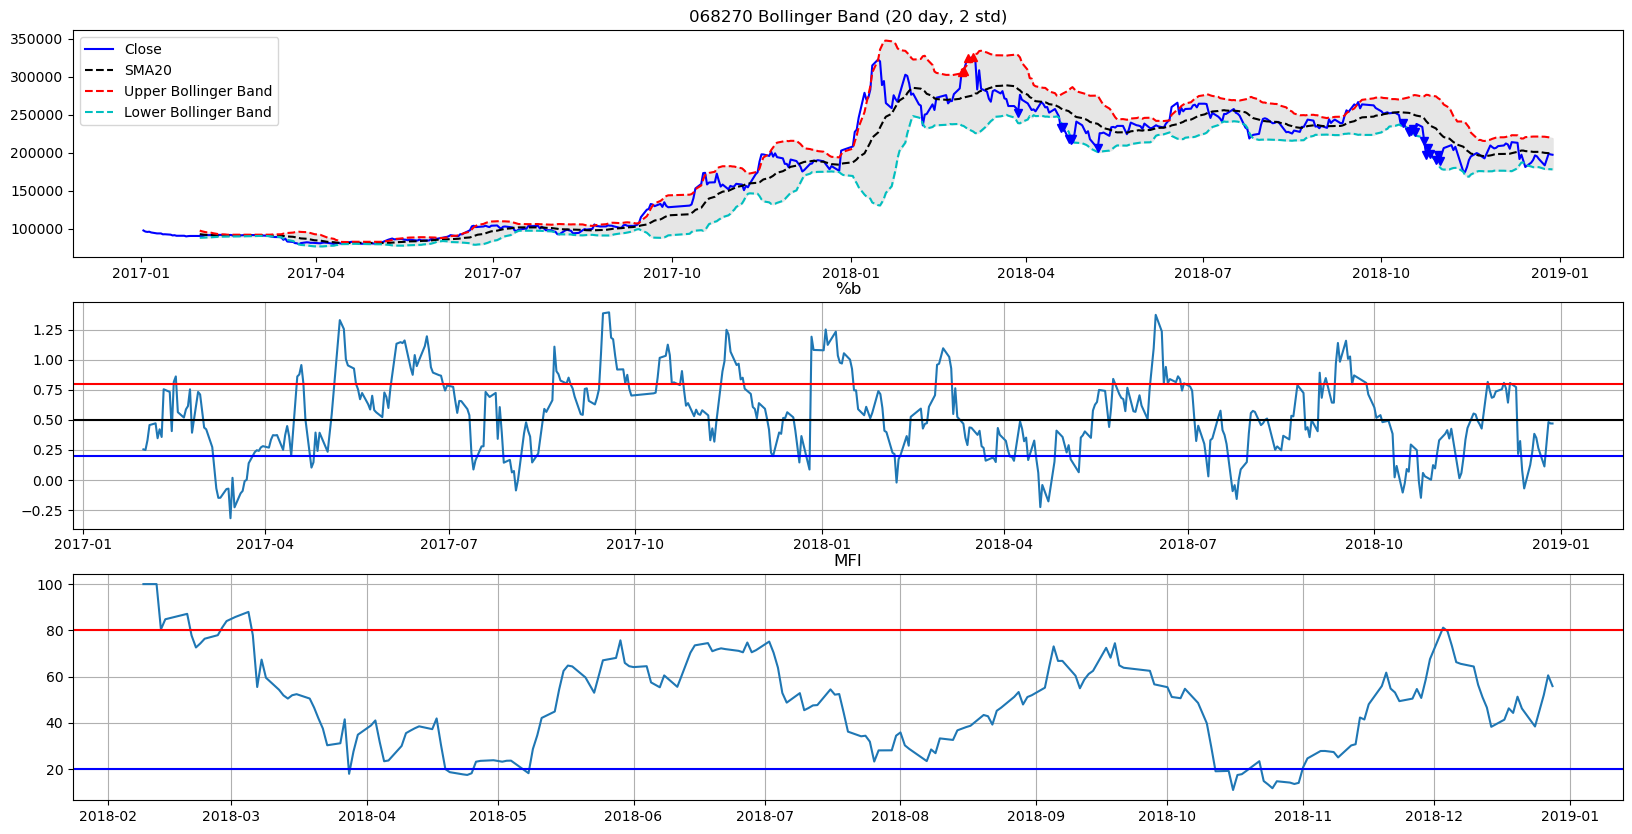

In [157]:
plot_trending('068270', '2017', '2019')

상승장에서도 마찬가지다. 

결론: 쓸 수 없는 전략. 

### Divergency Strategy

This strategy involves looking for divergences between %b and MFI. A bullish divergence occurs when %b makes a higher low while MFI makes a lower low. A bearish divergence occurs when %b makes a lower high while MFI makes a higher high. The strategy involves taking long positions when a bullish divergence occurs and short positions when a bearish divergence occurs.

divergence : price of asset 과 osciliator indicating 이 다른 방향으로 움직일 때 -> 추세가 기대됨.   
%b는 오르는데 MFI는 내려갈 때 -> 약세장으로 전환될 것이다.   
%b는 내려가는데 MFI는 올라갈 때 -> 강세장으로 전환될 것이다.

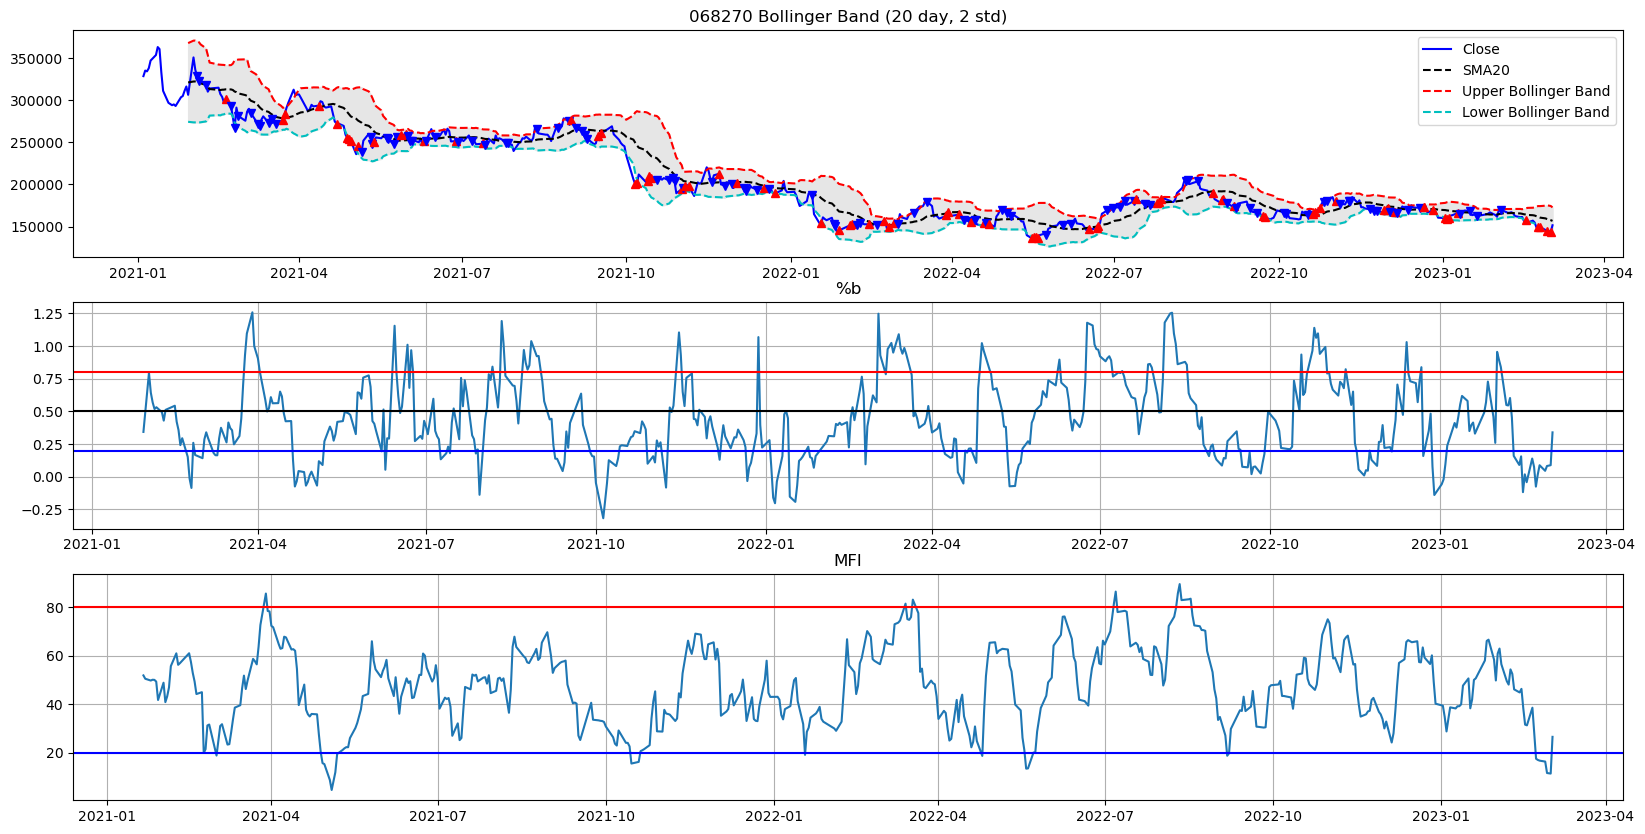

In [166]:
# Plot Bollinger Bands
def plot_divergence(stock, start, end=None):
    # get data
    df = fdr.DataReader(stock, start, end)

    # Calculate %b and MFI
    df['upper_band'], df['lower_band'], df['middle_band'] = bollinger_bands(df['Close'])
    df['percent_b'] = percent_b(df['Close'], df['upper_band'], df['lower_band'])
    df['mfi'] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])
    df['up_signal'] = False
    df['down_signal'] = False
    
    fig, axes = plt.subplots(3, 1, figsize=(20, 10))
    axes[0].plot(df.index, df["Close"], label="Close", color='#0000ff')
    axes[0].plot(df['middle_band'], 'k--',label="SMA20")
    axes[0].plot(df['upper_band'], 'r--', label="Upper Bollinger Band")
    axes[0].plot(df['lower_band'], 'c--', label="Lower Bollinger Band")
    axes[0].fill_between(df.index, df['upper_band'], df['lower_band'], color='0.9')
    axes[0].set_title(stock + ' Bollinger Band (20 day, 2 std)')
    axes[0].legend()

    axes[1].plot(df['percent_b'])
    axes[1].grid(True)
    axes[1].axhline(y=0.5, color='black')
    axes[1].axhline(y=0.8, color='red')
    axes[1].axhline(y=0.2, color='blue')
    axes[1].set_title('%b')


    axes[2].plot(df['mfi'])
    axes[2].set_title('MFI')
    axes[2].grid(True)
    axes[2].axhline(y=80, color='red')
    axes[2].axhline(y=20, color='blue')
    
    bullish_divergence = ((df['percent_b'].diff() > 0) & (df['mfi'].diff() < 0))
    bearish_divergence = ((df['percent_b'].diff() < 0) & (df['mfi'].diff() > 0))
    
    # Take long positions when a bullish divergence occurs and short positions when a bearish divergence occurs
    df['signal'] = 0
    df.loc[bullish_divergence, 'signal'] = 1
    df.loc[bearish_divergence, 'signal'] = -1
    
    df_index = df.index
    for index in df_index:
        if df.loc[index, 'signal'] == 1: # df['up_signal'] is True
            axes[0].plot(index, df.loc[index, 'Close'], marker='^', color='red')
        if df.loc[index, 'signal'] == -1: # df['down_signal'] is True
            axes[0].plot(index, df.loc[index, 'Close'], marker='v', color='blue')

    plt.show()
    
plot_divergence('068270', '2021')

너무 많은 거래량   
signal 기준을 diff로 하니까 단순한 임의적인 움직임이 미치는 영향이 너무 크다.

## MFI and %b breakout strategy

This strategy involves looking for breakouts in MFI and %b. A breakout in MFI occurs when the indicator moves above or below a certain threshold, indicating strong buying or selling pressure. A breakout in %b occurs when the indicator moves above or below the upper or lower Bollinger Band, indicating a potential trend reversal.

# MACD (The Moving Average Convergence Divergence)

The Moving Average Convergence Divergence (MACD) is a popular technical indicator used in technical analysis to identify changes in momentum, direction, and strength of a financial asset's price

In [1]:
import FinanceDataReader as fdr
import pandas as pd

In [4]:
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

data = df.copy()
# Calculate the 12-day EMA and 26-day EMA
ema_12 = data['Close'].ewm(span=12).mean()
ema_26 = data['Close'].ewm(span=26).mean()

# Calculate the MACD line
macd = ema_12 - ema_26

# Calculate the signal line
signal = macd.ewm(span=9).mean()

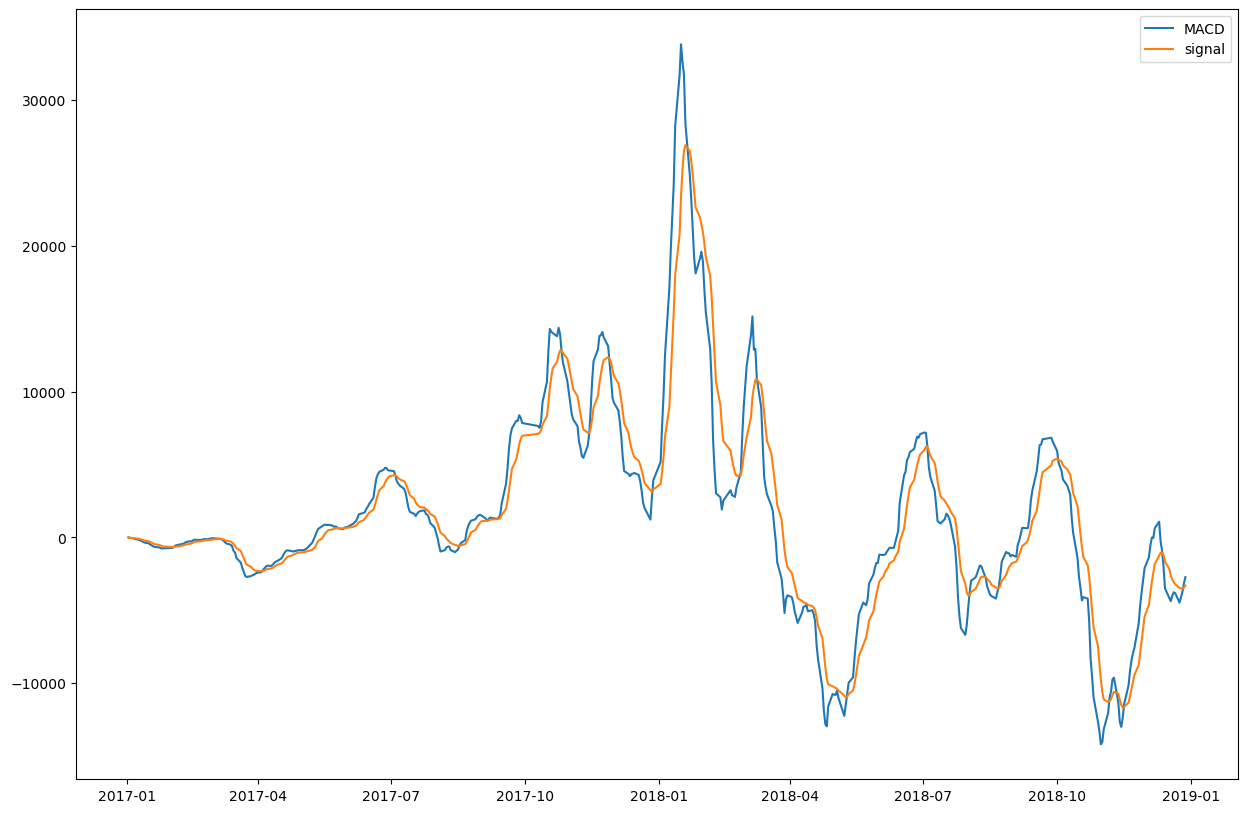

In [8]:
# Plot the MACD and signal lines
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(macd, label='MACD')
plt.plot(signal, label='signal')
plt.legend()
plt.show()

## MACD crossover strategy

A bullish signal is generated when the MACD line crosses above the signal line, indicating a potential buy opportunity, while a bearish signal is generated when the MACD line crosses below the signal line, indicating a potential sell opportunity.

MACD > signal -> bullish signal , MACD < signal -> bearish.

추세를 평활하게 판단할 수 있다. 보수적으로.   
이를 이용해 추세에 올라타는 전략.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load stock data from a CSV file
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

data = df.copy()

# Calculate the 12-day EMA and 26-day EMA
ema_12 = data['Close'].ewm(span=12).mean()
ema_26 = data['Close'].ewm(span=26).mean()

# Calculate the MACD line
macd = ema_12 - ema_26

# Calculate the signal line
signal = macd.ewm(span=9).mean()

# Create a new column to store the MACD crossover signals
data['MACD_signal'] = 0

# Generate the MACD crossover signals
for i in range(1, len(data)):
    if macd[i] > signal[i] and macd[i-1] < signal[i-1]: # 매수신호. 추세 전환 예측.
        data.iloc[i, 6] = 1 
    elif macd[i] < signal[i] and macd[i-1] > signal[i-1]: # 매도 신호. 추세 전환 예측.
        data.iloc[i, 6] = -1

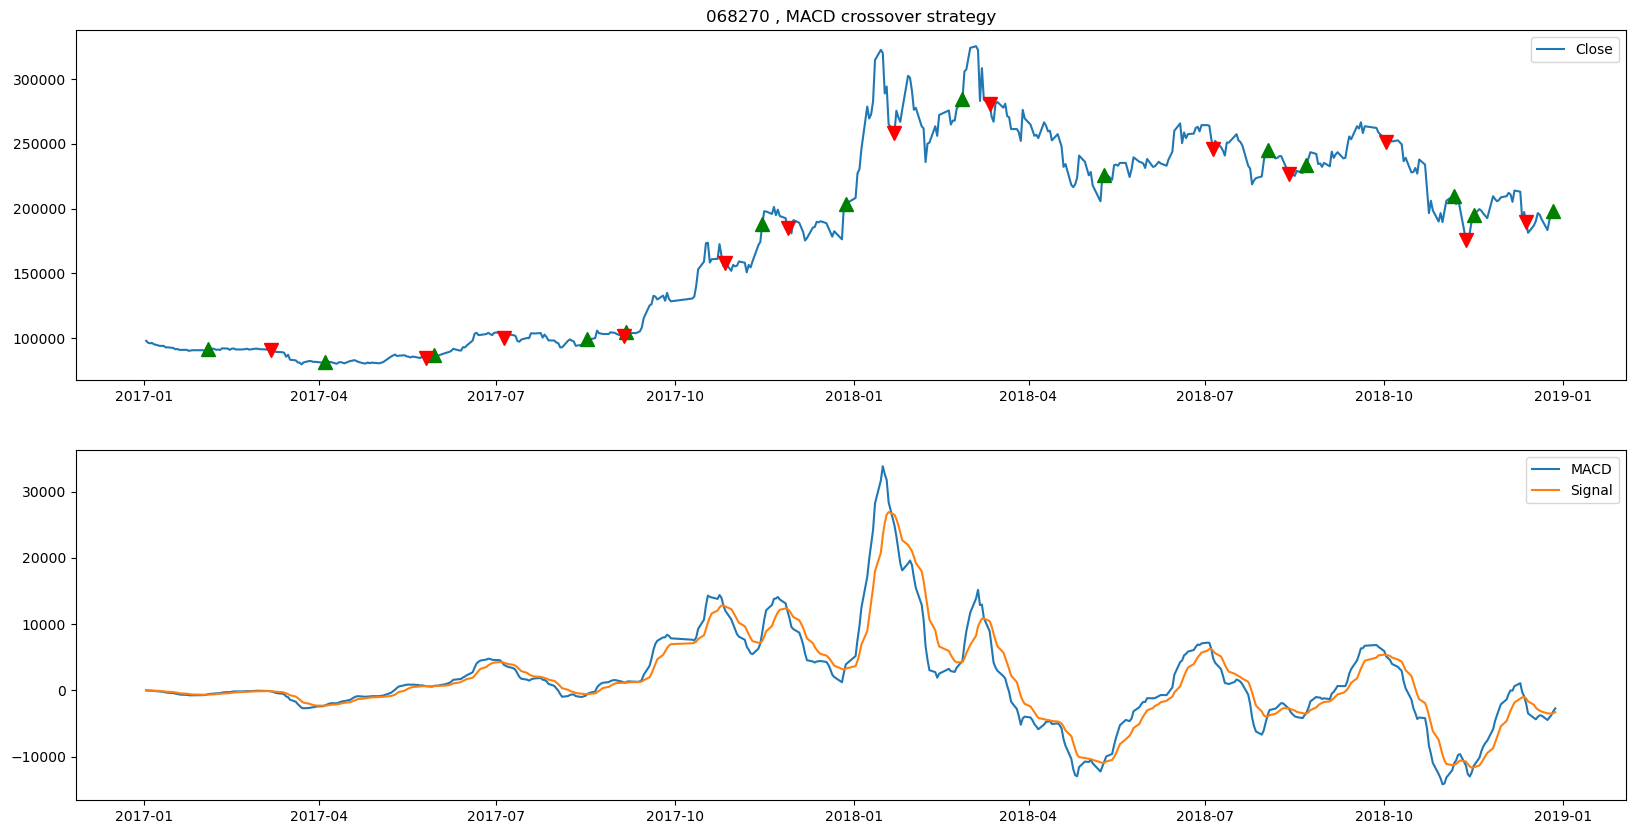

In [30]:
# Plot the MACD and signal lines with the crossover signals
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(data.index, data['Close'], label='Close')
axes[0].legend()
axes[0].set_title(f"{stock} , MACD crossover strategy")

axes[1].plot(macd, label='MACD')
axes[1].plot(signal, label='Signal')
axes[1].legend()


axes[0].plot(data[data['MACD_signal'] == 1].index, 
         data[data['MACD_signal'] == 1]['Close'], 
         '^', markersize=10, color='green', label='Buy')
axes[0].plot(data[data['MACD_signal'] == -1].index, 
         data[data['MACD_signal'] == -1]['Close'], 
         'v', markersize=10, color='red', label='Sell')

plt.show()

## MACD divergence strategy

This strategy involves looking for divergences between the MACD indicator and the price of the asset being traded. A bullish divergence occurs when the MACD indicator is making higher lows while the price is making lower lows, indicating a potential buy opportunity, while a bearish divergence occurs when the MACD indicator is making lower highs while the price is making higher highs, indicating a potential sell opportunity.

쉽게 말하면 MACD는 올라가는데 가격은 내려갈 때 -> bullish divergence가 기대되고 ,   
반대의 경우는 bearish divergence가 기대된다.

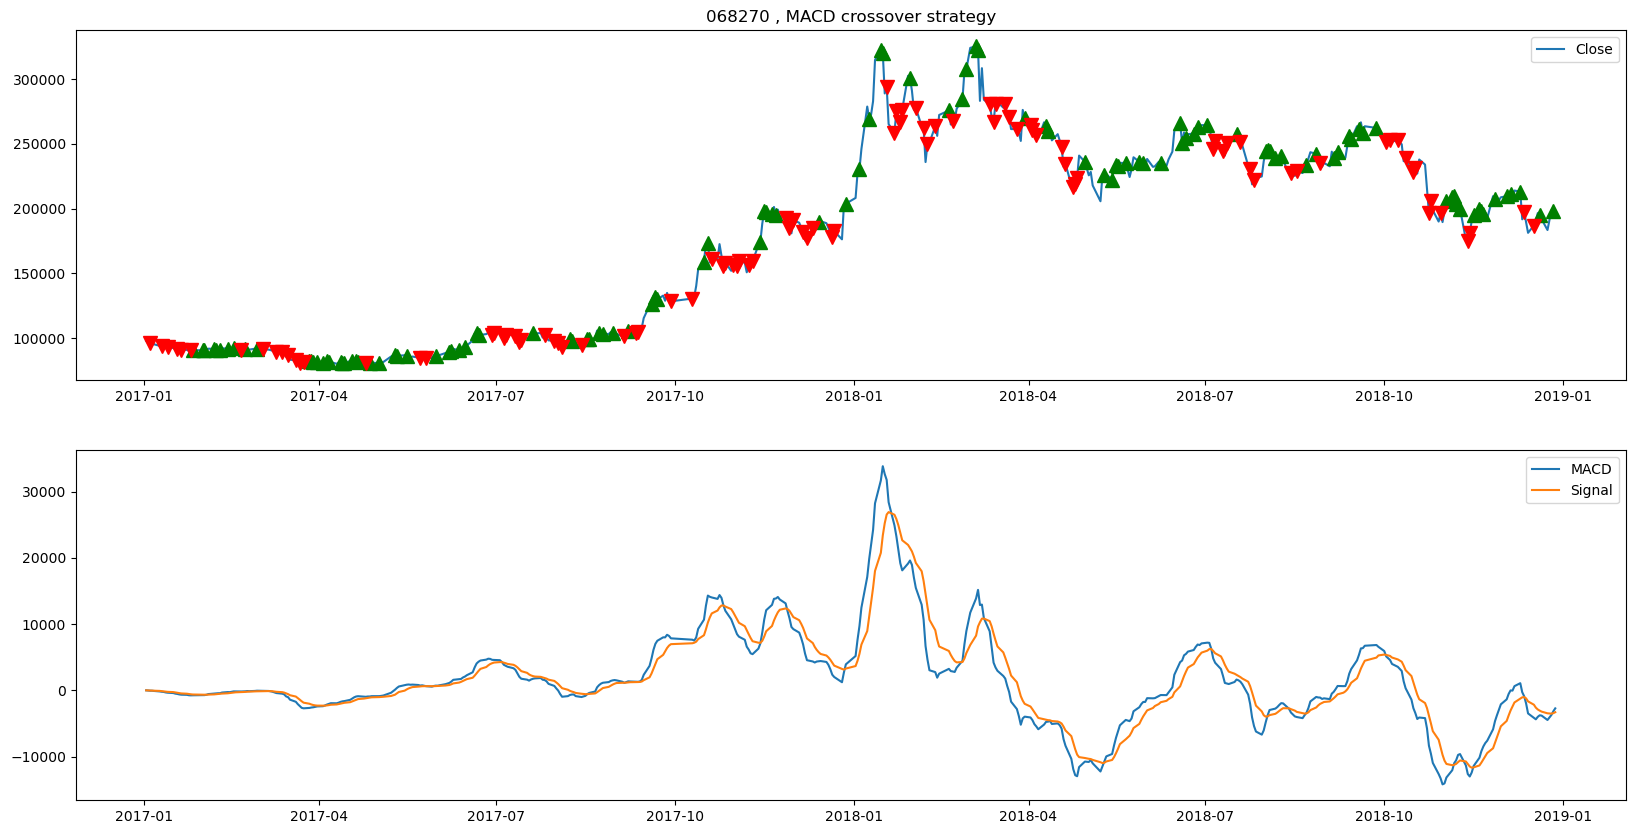

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load stock data from a CSV file
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

data = df.copy()

# Calculate the 12-day EMA and 26-day EMA
ema_12 = data['Close'].ewm(span=12).mean()
ema_26 = data['Close'].ewm(span=26).mean()

# Calculate the MACD line
macd = ema_12 - ema_26

# Calculate the price momentum
momentum = data['Close'].diff()

# Create a new column to store the MACD divergence signals
data['MACD_divergence'] = 0

# Generate the MACD divergence signals
for i in range(1, len(data)):
    if macd[i] > macd[i-1] and momentum[i] < momentum[i-1]:
        data.iloc[i, 6] = 1
    elif macd[i] < macd[i-1] and momentum[i] > momentum[i-1]:
        data.iloc[i, 6] = -1

# Plot the MACD and signal lines with the crossover signals
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(data.index, data['Close'], label='Close')
axes[0].legend()
axes[0].set_title(f"{stock} , MACD crossover strategy")

axes[1].plot(macd, label='MACD')
axes[1].plot(signal, label='Signal')
axes[1].legend()


axes[0].plot(data[data['MACD_divergence'] == 1].index, 
         data[data['MACD_divergence'] == 1]['Close'], 
         '^', markersize=10, color='green', label='Buy')
axes[0].plot(data[data['MACD_divergence'] == -1].index, 
         data[data['MACD_divergence'] == -1]['Close'], 
         'v', markersize=10, color='red', label='Sell')

plt.show()


추세가 전환될 것이라는 기대와 다르게, 추세를 잘 맞추고 있다..?

## MACD histogram strategy

This strategy involves looking for changes in the MACD histogram, which represents the difference between the MACD line and the signal line. A bullish signal is generated when the MACD histogram crosses above the zero line, indicating a potential buy opportunity, while a bearish signal is generated when the MACD histogram crosses below the zero line, indicating a potential sell opportunity.

MACD 히스토그램이 0보다 크면 bullish signal , 0보다 작으면 bearish signal. 

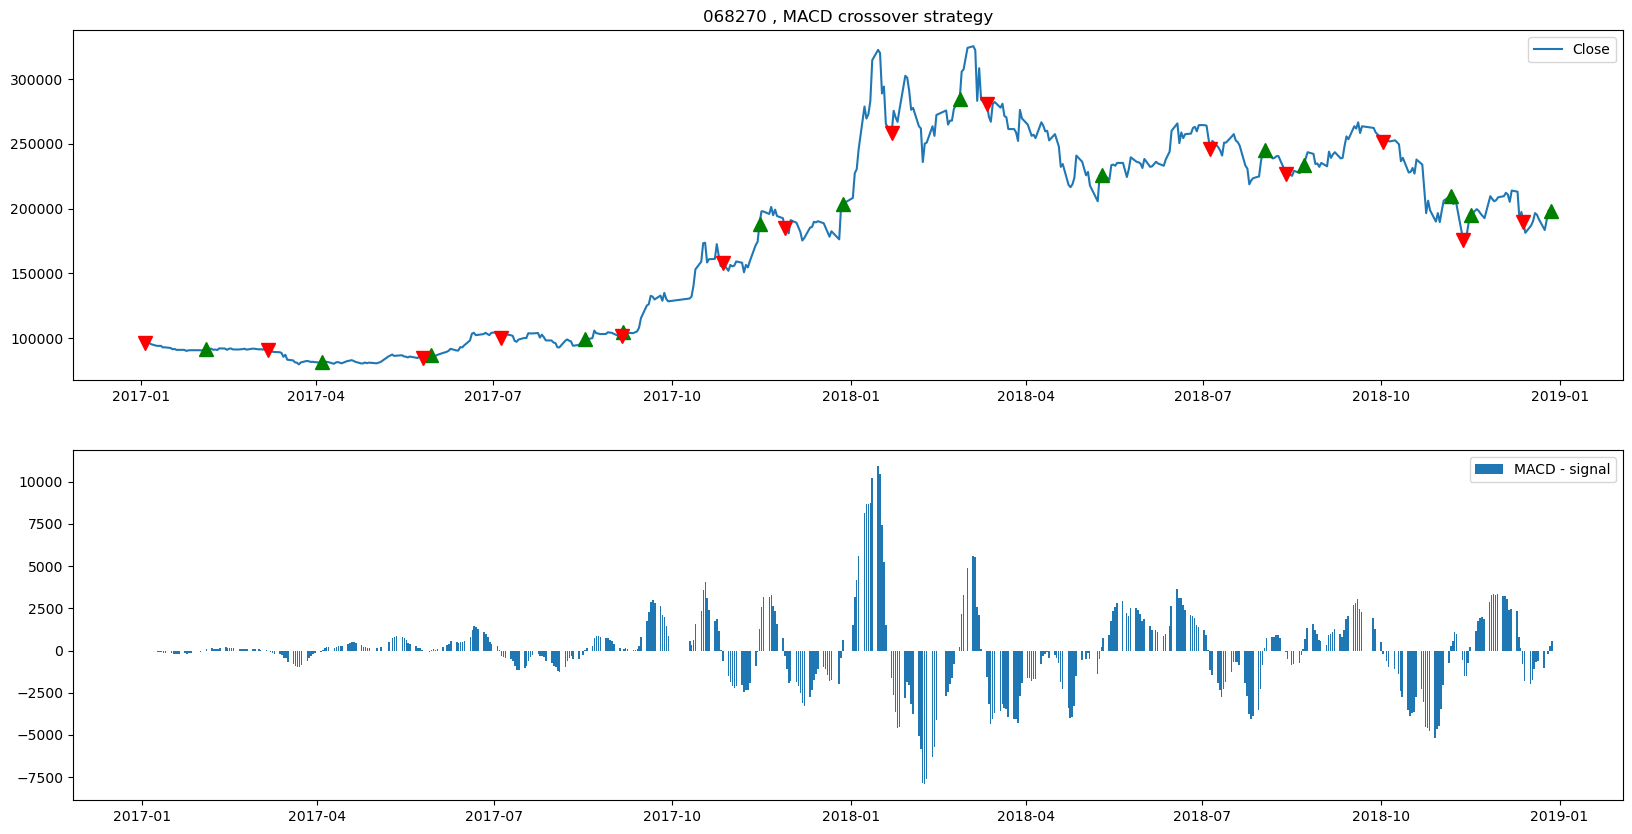

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load stock data from a CSV file
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

data = df.copy()
# Calculate the 12-day EMA and 26-day EMA
ema_12 = data['Close'].ewm(span=12).mean()
ema_26 = data['Close'].ewm(span=26).mean()

# Calculate the MACD line and the signal line
macd = ema_12 - ema_26
signal = macd.ewm(span=9).mean()

# Create a new column to store the MACD crossover signals
data['MACD_crossover'] = 0

# Generate the MACD crossover signals
for i in range(1, len(data)):
    if macd[i] > signal[i] and macd[i-1] <= signal[i-1]:
        data.iloc[i, 6] = 1
    elif macd[i] < signal[i] and macd[i-1] >= signal[i-1]:
        data.iloc[i, 6] = -1

# Plot the MACD and signal lines with the crossover signals
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(data.index, data['Close'], label='Close')
axes[0].legend()
axes[0].set_title(f"{stock} , MACD crossover strategy")

axes[1].bar(data.index, macd-signal, label='MACD - signal')
axes[1].legend()


axes[0].plot(data[data['MACD_crossover'] == 1].index, 
         data[data['MACD_crossover'] == 1]['Close'], 
         '^', markersize=10, color='green', label='Buy')
axes[0].plot(data[data['MACD_crossover'] == -1].index, 
         data[data['MACD_crossover'] == -1]['Close'], 
         'v', markersize=10, color='red', label='Sell')

plt.show()


# Stochastic Osiliators

가격의 변동폭에 기반한 지표    
%K = (Current Close - Lowest Low) / (Highest High - Lowest Low) * 100    
%D = 3-day moving average of %K    
80이 넘으면 과매수, 20보다 작으면 과매도를 의심한다.   
Williams %R : %K와 계산이 같으나 -100 ~0 값을 가짐

%K 의 의미 -> 값이 낮으면 저가에 팔리고 있다. 높으면 고가에 팔리고 있다.

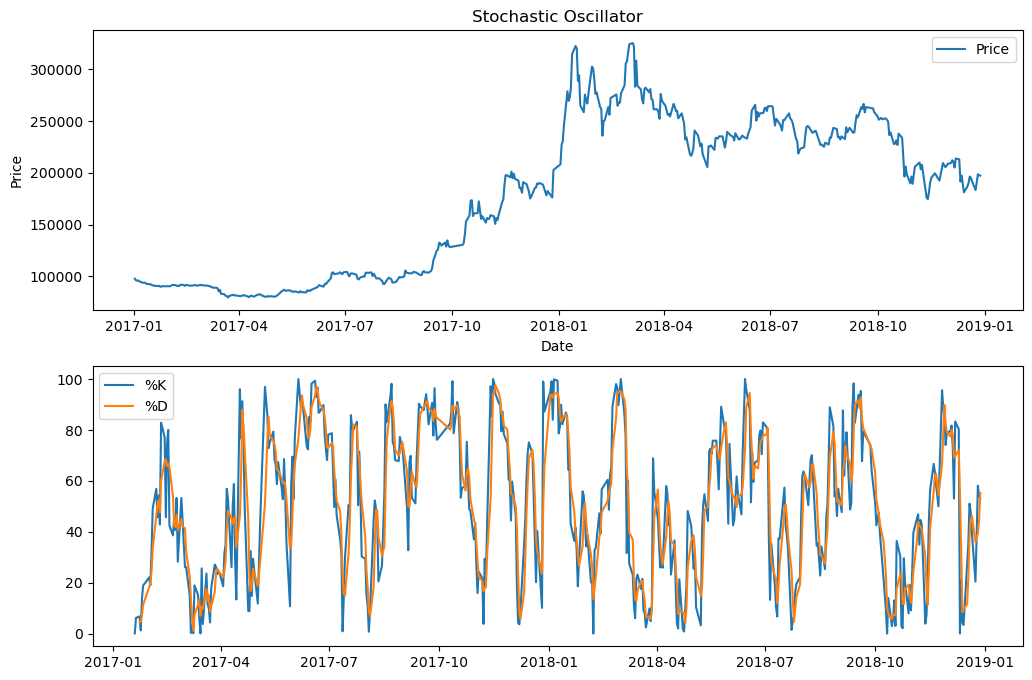

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# Load historical price data for a security
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

# Set the period length for the stochastic oscillator
period = 14

# Calculate the lowest low and highest high for the given period
df['Lowest Low'] = df['Low'].rolling(window=period).min()
df['Highest High'] = df['High'].rolling(window=period).max()

# Calculate the %K line and %D line
df['%K'] = (df['Close'] - df['Lowest Low']) / (df['Highest High'] - df['Lowest Low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

# Plot the price data and stochastic oscillator
fig, axes = plt.subplots(2, 1,figsize=(12,8))

axes[0].plot(df.index, df['Close'], label='Price')
axes[1].plot(df.index, df['%K'], label='%K')
axes[1].plot(df.index, df['%D'], label='%D')

axes[0].set(title='Stochastic Oscillator', xlabel='Date', ylabel='Price')
axes[0].legend()
axes[1].legend()

plt.show()


## Overbought/Oversold Strategy

%K > 80 -> overbougt, %K < 20 -> oversold

역추세 전략.

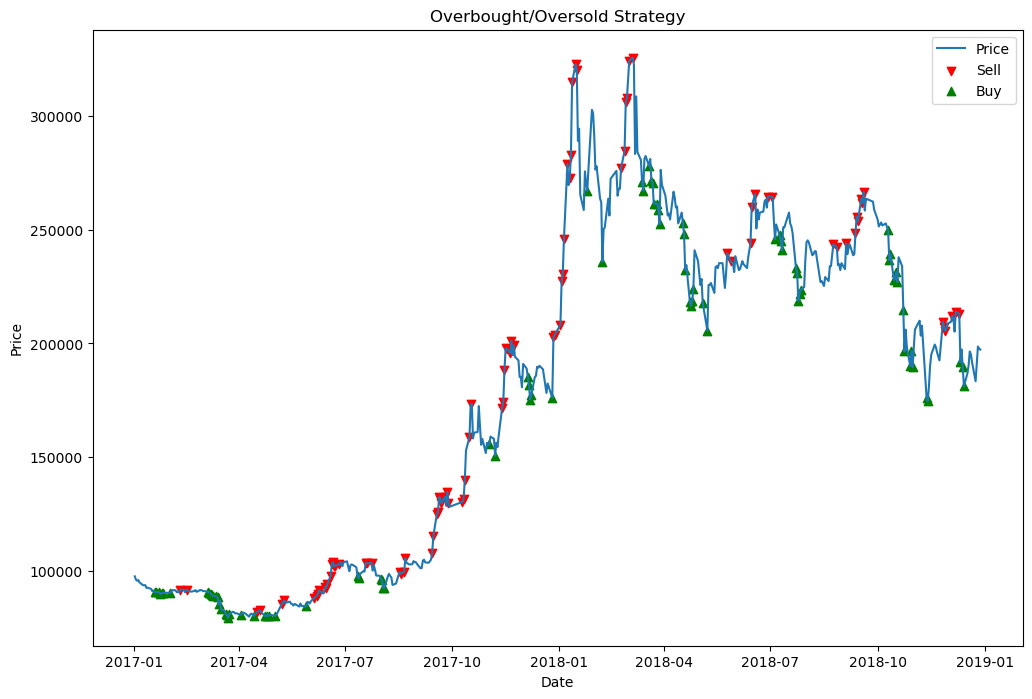

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Load historical price data for a security
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

# Set the period length for the stochastic oscillator
period = 14

# Calculate the lowest low and highest high for the given period
df['Lowest Low'] = df['Low'].rolling(window=period).min()
df['Highest High'] = df['High'].rolling(window=period).max()

# Calculate the %K line and %D line
df['%K'] = (df['Close'] - df['Lowest Low']) / (df['Highest High'] - df['Lowest Low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

# Set the overbought and oversold thresholds
overbought = 80
oversold = 20

# Create a new column with buy/sell signals based on the overbought/oversold conditions
df['Signal'] = None
df.loc[df['%K'] > overbought, 'Signal'] = 'Sell'
df.loc[df['%K'] < oversold, 'Signal'] = 'Buy'

# Plot the price data and signals
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df.index, df['Close'], label='Price')
ax.scatter(df[df['Signal'] == 'Sell'].index, df[df['Signal'] == 'Sell']['Close'], marker='v', color='red', label='Sell')
ax.scatter(df[df['Signal'] == 'Buy'].index, df[df['Signal'] == 'Buy']['Close'], marker='^', color='green', label='Buy')

ax.set(title='Overbought/Oversold Strategy', xlabel='Date', ylabel='Price')
ax.legend()

plt.show()


## bullish/bearish divergence strategy

가격은 내려가는데 %K는 올라갈 때 -> Buy.   
가격은 올라가는데 %K는 내려갈 때 -> Sell.

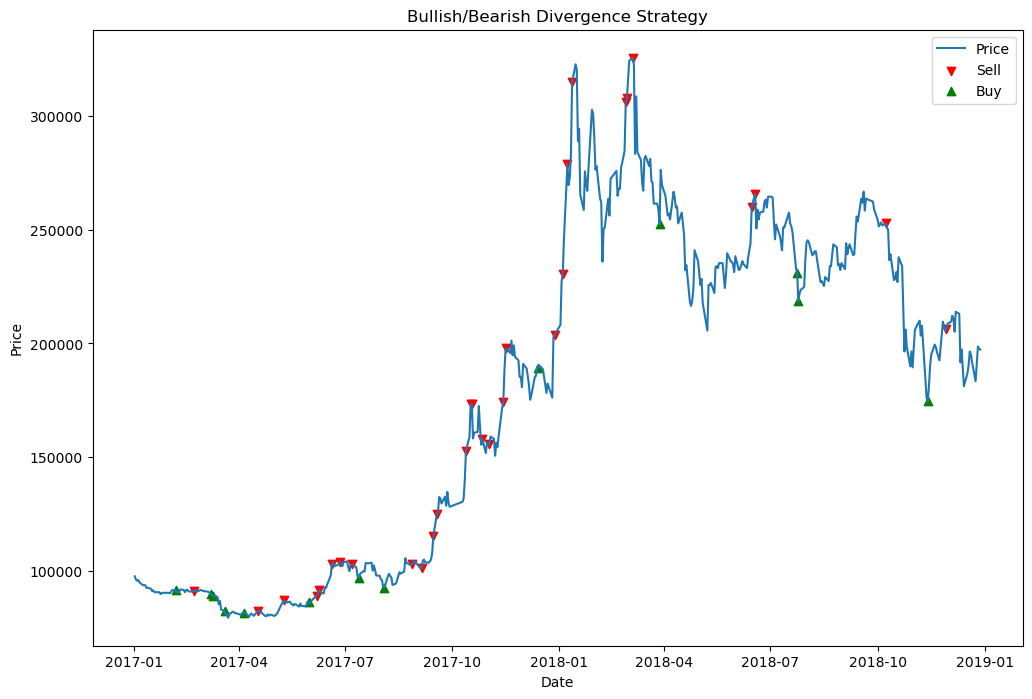

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load historical price data for a security
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

# Set the period length for the stochastic oscillator
period = 14

# Calculate the lowest low and highest high for the given period
df['Lowest Low'] = df['Low'].rolling(window=period).min()
df['Highest High'] = df['High'].rolling(window=period).max()

# Calculate the %K line and %D line
df['%K'] = (df['Close'] - df['Lowest Low']) / (df['Highest High'] - df['Lowest Low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

# Calculate the price change and the %K change from the previous period
df['Price Change'] = df['Close'].diff()
df['%K Change'] = df['%K'].diff()

# Create a new column with buy/sell signals based on the bullish/bearish divergence conditions
df['Signal'] = None
df.loc[(df['Price Change'] < 0) & (df['%K Change'] > 0), 'Signal'] = 'Buy'
df.loc[(df['Price Change'] > 0) & (df['%K Change'] < 0), 'Signal'] = 'Sell'

# Plot the price data and signals
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df.index, df['Close'], label='Price')
ax.scatter(df[df['Signal'] == 'Sell'].index, df[df['Signal'] == 'Sell']['Close'], marker='v', color='red', label='Sell')
ax.scatter(df[df['Signal'] == 'Buy'].index, df[df['Signal'] == 'Buy']['Close'], marker='^', color='green', label='Buy')

ax.set(title='Bullish/Bearish Divergence Strategy', xlabel='Date', ylabel='Price')
ax.legend()

plt.show()


## Crossover Strategy
n this strategy, traders look for crossovers between the %K and %D lines of the stochastic oscillator. When the %K line crosses above the %D line, it is considered a bullish signal. When the %K line crosses below the %D line, it is considered a bearish signal. Traders can use these signals to enter or exit positions accordingly.

%K가 %D 아래에 있다가 올라오고, %K가 80작으면 -> 매수.    
%K가 %D보다 위에 있다가 내려가고, %K가 20보다 크면 매도.

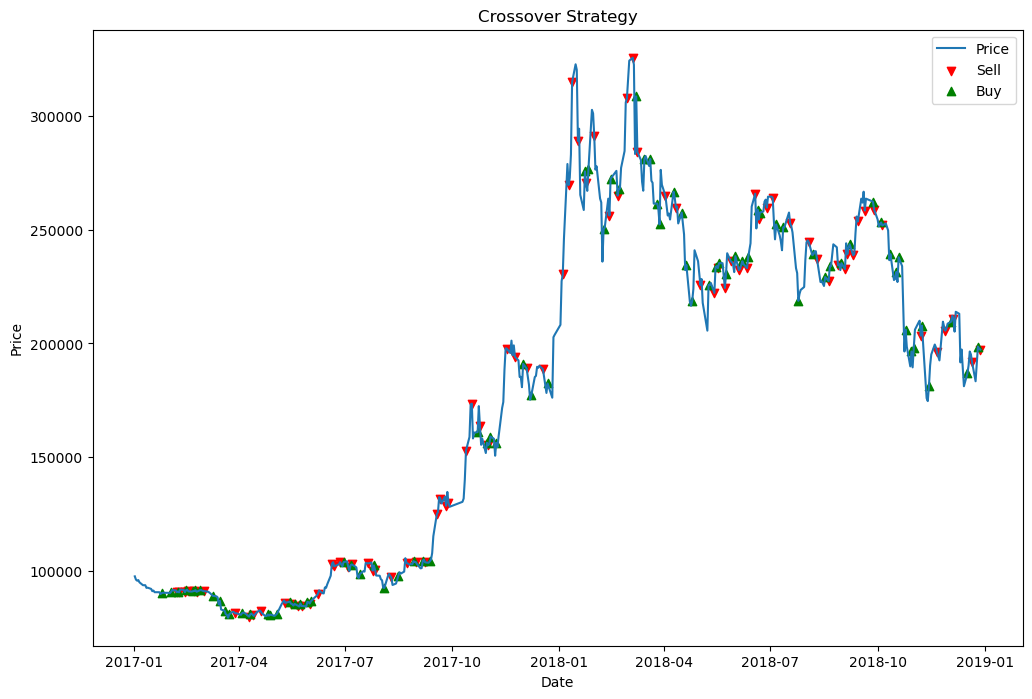

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Load historical price data for a security
stock = '068270'; start = '2017'; end = '2019' 
df = fdr.DataReader(stock, start, end)

# Set the period length for the stochastic oscillator and the moving average
period = 14
ma_period = 50

# Calculate the lowest low and highest high for the given period
df['Lowest Low'] = df['Low'].rolling(window=period).min()
df['Highest High'] = df['High'].rolling(window=period).max()

# Calculate the %K line and %D line
df['%K'] = (df['Close'] - df['Lowest Low']) / (df['Highest High'] - df['Lowest Low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

# Calculate the moving average
df['MA'] = df['Close'].rolling(window=ma_period).mean()

# Create a new column with buy/sell signals based on the crossover condition
df['Signal'] = None
df.loc[(df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1)) & (df['%K'] < 80), 'Signal'] = 'Buy'
df.loc[(df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1)) & (df['%K'] > 20), 'Signal'] = 'Sell'

# Plot the price data and signals
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df.index, df['Close'], label='Price')
ax.scatter(df[df['Signal'] == 'Sell'].index, df[df['Signal'] == 'Sell']['Close'], marker='v', color='red', label='Sell')
ax.scatter(df[df['Signal'] == 'Buy'].index, df[df['Signal'] == 'Buy']['Close'], marker='^', color='green', label='Buy')

ax.set(title='Crossover Strategy', xlabel='Date', ylabel='Price')
ax.legend()

plt.show()


# 모멘텀

이런 차트지표 말고 기본적인 것들에 대해 깊게 살펴보자.  
듀얼 모멘텀, 상대 모멘텀, 절대 모멘텀 같은 것들.    
과거 수익률에 기반해서 선택하는 전략들.